<a href="https://colab.research.google.com/github/mrazimi99/ImageClassification/blob/master/ImageClassification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<h1 lang="fa" dir="rtl" align=center>
طبقه بندی تصاویر
با شبکه عصبی چند لایه
</h1>
<h2 lang="fa" dir="rtl" align=center>
محمدرضا عظیمی
</h2>
<h3 lang="fa" dir="rtl" align=center>
810196510
</h3>

<div lang="fa" dir="rtl">
<h2>
مقدمه
</h2>
<p>
میخواهیم با استفاده از شبکه های عصبی و آموزش دادن آن ها، دسته بندی تصاویر مختلف را انجام دهیم.
<br>
برای این کار نیاز است که شبکه ی عصبی خود را با تعداد لایه ها و نورون های متفاوتی آموزش دهیم و بهترین تعداد را برای لایه ها و نورون ها انتخاب کنیم.
<br>
از آنجاییکه با داشتن دو لایه ی میانی میتوان هر تابع غیر خطی ای را مدل کرد، آموزش را با دو لایه آغاز کرده و تمرکز خود را بر تعداد نورون ها می گذاریم.
</p>

<p>
در این قسمت ابتدا package
های مورد نیاز را import می کنیم.
<br>
همچنین در این پروژه از ابزار موجود در pytorch
استفاده خواهیم کرد.
</p>
</div>

In [ ]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
from random import sample
import numpy as np
import matplotlib.pyplot as plt
import math

from torch.utils.data import Dataset, DataLoader, random_split
from torchvision.datasets import ImageFolder
from torch.utils.data.sampler import SubsetRandomSampler

from sklearn.model_selection import train_test_split

import time
from datetime import timedelta
from datetime import datetime

import os.path

<div lang="fa" dir="rtl">
<h2>
بارگیری داده ها
</h2>
<p>
ابتدا داده های مورد نیاز برای train و test
را بارگیری می کنیم.
<br>
برای کمینه کردن تعداد دفعات دانلود در اجراهای مختلف، ابتدا وجود پوشه ی تصاویر را بررسی کرده و درصورت عدم وجود، آن را بارگیری می کنیم.
</p>
</div>

In [ ]:
if not os.path.isdir("categorized_products"):
    !gdown --id "1aFjcSk9hBzsHusrjO3UjCg4xQo9Ubdr1"
    !unzip "categorized_products"

<div lang="fa" dir="rtl">
<p>
در این قسمت کلاس CustomToTensor را 
پیاده سازی کرده و عملگر پرانتز را برای آن overload
می کنیم.
<br>
این تابع تصویر را دریافت کرده و آن را بصورت یک Tensor
و بدون scale کردن برمی گرداند.
</p>
</div>

In [ ]:
class CustomToTensor(object):
    def __call__(self, image):
        image = np.array(image, dtype=np.float32)
        return torch.from_numpy(image)

<div lang="fa" dir="rtl">
<p>
با استفاده از تابع Compose
می توان تبدیل های مختلفی را بر روی مجموعه داده اعمال کرد.
<br>
در این قسمت دو تبدیل را بر روی تصاویر اعمال می کنیم.
<br>
برای هر تصویر ابتدا آن را در محدوده سیاه و سفید برده و سپس به Tensor
تبدیل می کنیم.
<br>
حال تابع ImageFolder
را فراخوانی کرده و پوشه ی داده ها و نیز object ساخته شده
برای تبدیل هر تصویر را بعنوان ورودی به آن می دهیم.
<br>
همچنین کلاس های موجود در مجموعه ی داده را گرفته و در متغیر classes
برای استفاده های بعدی ذخیره می کنیم.
</p>
</div>

In [ ]:
transform = transforms.Compose([transforms.Grayscale(), CustomToTensor()])
scaled_transform = transforms.Compose([transforms.Grayscale(), transforms.ToTensor()])
dataset = ImageFolder("categorized_products" , transform=transform)
scaled_dataset = ImageFolder("categorized_products" , transform=scaled_transform)
classes = dataset.classes

<div lang="fa" dir="rtl">
<h2>
بخش اول
</h2>
<p>
برای اطمینان از صحت عملکرد خود تا به اینجای کار، تابعی برای نمایش تعدادی از عکس ها می نویسیم.
<br>
این تابع لیستی از تصاویر و کلاس متناظرشان را گرفته و آن ها را در سه ردیف چهارتایی به نمایش می گذارد.
<br>
از آنجاییکه تبدیل سیاه و سفید را روی این تصاویر انجام داده بودیم، خروجی شامل تصاویر سیاه و سفید خواهد بود.
<br>
در نهایت 12 مورد از تصاویر موجود در مجموعه داده را انتخاب کرده و آن هارا به این تابع می دهیم تا نتیجه ی کار خود را مشاهده کنیم.
</p>
</div>

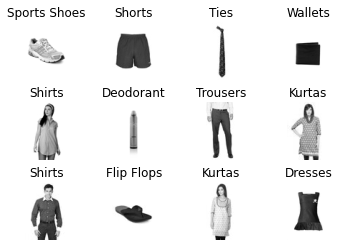

In [ ]:
def imshow(img_array, labels, classes):
    _, axs = plt.subplots(3, 4) 
    for i in range(3):
      for j in range(4):
        axs[i][j].imshow(img_array[i * 4 + j], cmap='gray')
        axs[i][j].set_title(classes[labels[i * 4 + j]])
        axs[i][j].axis('off')
    plt.subplots_adjust(hspace=0.4)
    plt.show()

elements = sample(list(dataset), 12)
images = [elem[0] for elem in elements]
labels = [elem[1] for elem in elements]

imshow(images, labels, classes)

<div lang="fa" dir="rtl">
<h2>
بخش دوم
</h2>
<h3>
الف
</h3>
<p>
در این قسمت می خواهیم نحوه ی توزیع تصاویر در انواع محصولات را مشاهده کنیم.

برای این منظور تابعی را تعریف می کنیم که loader
مربوطه و نیز نام کلاس های مختلف را بعنوان ورودی گرفته و نمودار توزیع تصاویر در دسته های مختلف را بصورت نزولی رسم می کند.
</p>
</div>

In [ ]:
def plot_image_distribution(loader, classes):
    total_category_count = {class_ : 0 for class_ in classes}

    for _, labels in loader:
        total_category_count[ classes[labels] ] += 1

    sorted_classes = list({k: v for k, v in reversed(sorted(total_category_count.items(), key=lambda item: item[1]))}.items())
    x, y = zip(*sorted_classes)
    fig=plt.figure(figsize=(30, 9), dpi= 80, facecolor='w', edgecolor='k')
    plt.rcParams["axes.labelweight"] = "bold"
    plt.rcParams.update({'font.size': 12})
    plt.bar(x, y)
    plt.gca().set_xlim(xmin=-0.5, xmax=len(sorted_classes))
    plt.title("Each Category's Frequency", fontweight="bold")
    plt.xticks(rotation=90)
    plt.yticks(np.arange(0, max(total_category_count.values()) + 200, 200.0))
    plt.xlabel("Category")
    plt.ylabel("Frequency")
    plt.show()

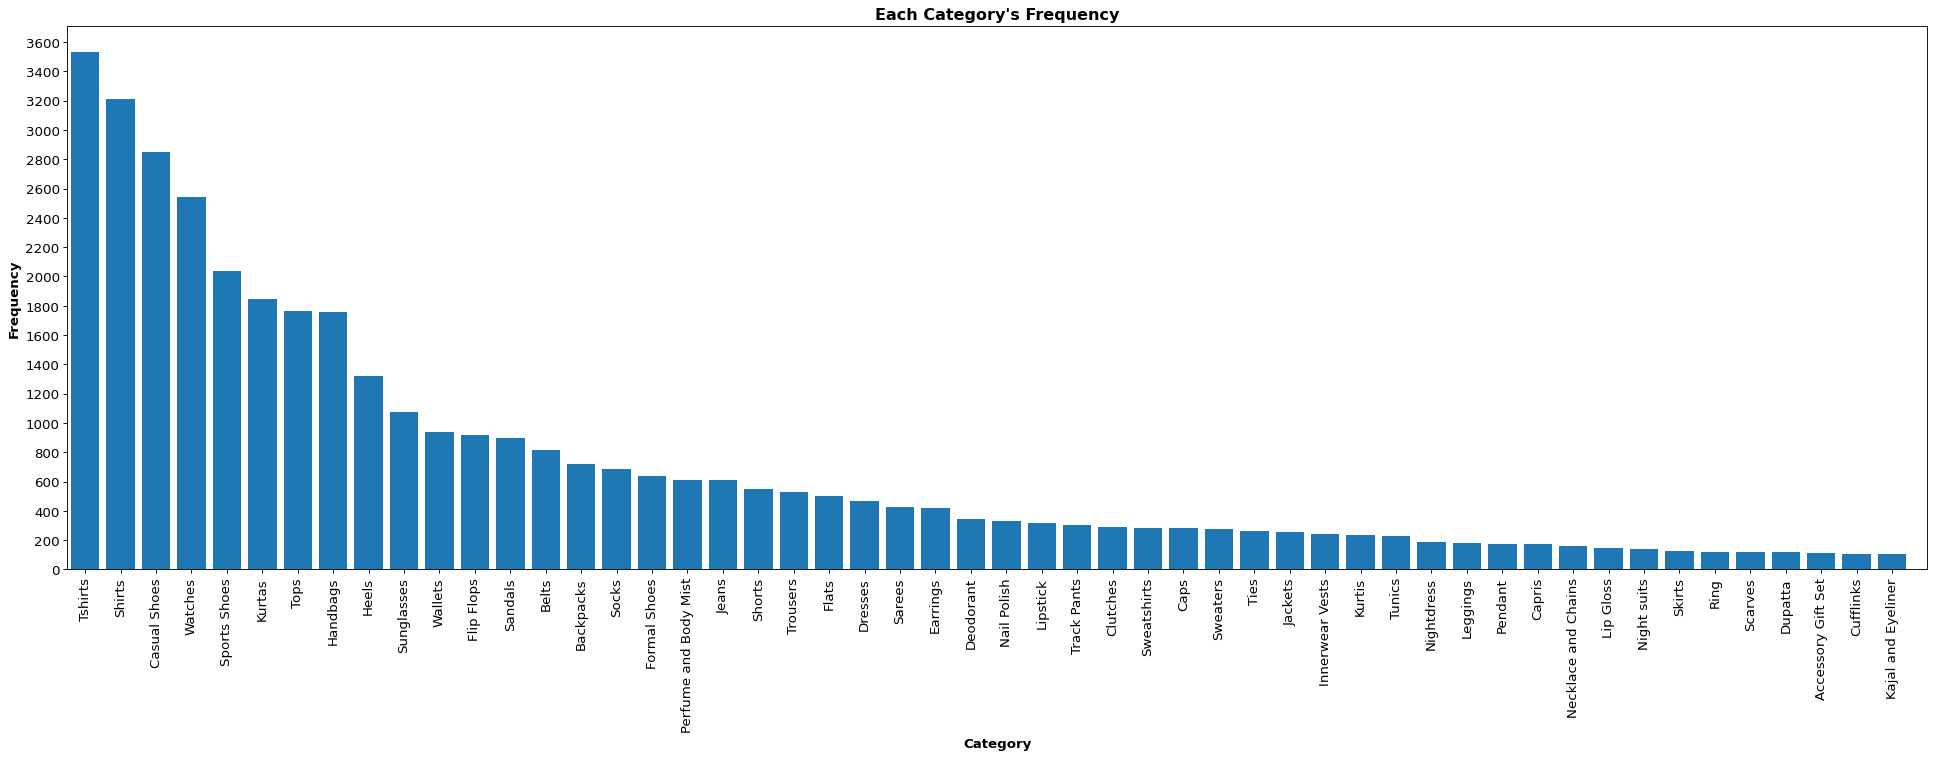

In [ ]:
plot_image_distribution(list(dataset), classes)

<div lang="fa" dir="rtl">
<h2>
بخش دوم
</h2>
<h3>
الف
</h3>
<p>
همانطور که در نمودار مشاهده می کنیم، بیشترین تراکم در دسته ی Tshirts و کمترین تراکم
در دسته ی Kajal and Eyeliner
قرار دارد.

تفاوت تعداد تصاویر بین این دو کلاس بسیار زیاد است و همانطور که در نمودار مشاهده می شود، توزیع تصاویر در میان دسته ها بسیار نامتوازن است.

برای رفع این مشکل و متوازن کردن توزیع داده ها می توان از روش های oversampling استفاده کرد.
</p>
</div>

<div lang="fa" dir="rtl">
<h3>
ب
</h3>
<p>
در این بخش می خواهیم مجموعه ی داده ها را به دو دسته ی تست و آموزش تقسیم کنیم.

این کار باید بصورت تصادفی انجام شود و جداسازی طوری باشد که از هر دسته بطور تصادفی 20 درصد آن در مجموعه داده های تست و 80 درصد آن در مجموعه داده های آموزش قرار گیرد.

برای این کار از تابع train_test_split
موجود در کتابخانه ی scikit
استفاده می کنیم.

این تابع مجموعه داده ها و نسبت سهم داده های تست (و یا آموزش) به کل داده ها (که در اینجا برای داده های تست 20 درصد است) را بعنوان ورودی گرفته و آن ها را طوری به دو دسته تقسیم می کند که از هر کلاس موجود، نسبت یکسانی انتخاب شود.

این کار بر اساس آرایه ی برچسب ها که بعنوان پارامتر stratify
به تابع پاس دادیم انجام می شود.
</p>
</div>

In [ ]:
labels = [elem[1] for elem in dataset]
validation_split = 0.2
train_all, test_all, Y_train, Y_test = train_test_split(dataset, labels, test_size=validation_split, random_state=42, stratify=labels)
scaled_train, scaled_test, scaled_Y_train, scaled_Y_test = train_test_split(scaled_dataset, labels, test_size=validation_split, random_state=42, stratify=labels)

<div lang="fa" dir="rtl">
<h2>
بخش سوم
</h2>
<p>
در این بخش می خواهیم یک مدل شبکه عصبی چند لایه را پیاده سازی کرده و سپس آن را بر روی تصاویر fit کنیم.

ابتدا با استفاده از توابع pytroch
و داده های آموزش و تست که آن ها را در بخش قبلی جدا کردیم، Data Loader ها را
برای هر کدام از مجموعه داده های آموزش و تست می سازیم.

در ابتدا اندازه ی batch size
را برابر 64 قرار می دهیم.
</p>
</div>

In [ ]:
batch_size = 64
train_loader = torch.utils.data.DataLoader(train_all, batch_size=batch_size, num_workers=16)
test_loader = torch.utils.data.DataLoader(test_all, batch_size=batch_size, num_workers=16)
scaled_train_loader = torch.utils.data.DataLoader(scaled_train, batch_size=batch_size, num_workers=16)
scaled_test_loader = torch.utils.data.DataLoader(scaled_test, batch_size=batch_size, num_workers=16)

<div lang="fa" dir="rtl">
<p>
اکنون کلاس Model
را پیاده سازی می کنیم.

این کلاس از کلاس nn.Module
ارث بری می کند. در حقیقت برای ساختن یک مدل می بایست آن را فرزند کلاس nn.Module
قرار داده و سپس لایه های شبکه ی خود را طراحی کرده و تابع forward
را برای آن override
کنیم.

کلاسی که تعریف می کنیم، در هنگام ساخته شدن، تعداد نورون های لایه های میانی شبکه، activation function و تعداد
نورون های لایه های ورودی و خروجی را می گیرد و لایه های شبکه را می سازد.
</p>
</div>

In [ ]:
class Model(nn.Module):
    def __init__(self, input_num, middle_layers, output_num, act):
        super(Model, self).__init__()
        self.layers = nn.ModuleList()
        self.acts = []

        self.layers.append(nn.Linear(input_num, middle_layers[0]))
        self.acts.append(act)

        for i in range(len(middle_layers) - 1):
            self.layers.append(nn.Linear(middle_layers[i], middle_layers[i + 1]))
            self.acts.append(act)

        self.layers.append(nn.Linear(middle_layers[-1], output_num))

    def forward(self, x):

        x = x.view(x.size(0), -1)

        for i in range(len(self.layers) - 1):
            x = self.layers[i](x)
            x = self.acts[i](x)

        x = self.layers[-1](x)
        return x

<div lang="fa" dir="rtl">
<p>
حال چون از منابع GPU ای که
colab
در اختیارمان می گذارد استفاده می کنیم، پارامتر device
برای مدل خود را به cuda تنظیم می کنیم
تا از GPU به خوبی استفاده شود.
</p>
</div>

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [ ]:
print(device)

cuda:0


<div lang="fa" dir="rtl">
<p>
در این قسمت توابعی برای fit کردن مدل و نیز
تست کردن آن تعریف میکنیم تا در آینده و برای بررسی و مقایسه ی حالات مختلف، فقط پارامترها را تغییر داده و توابع مورد نیاز را صرفا صدا بزنیم.
</p>
</div>

In [ ]:
def fit(model, train_loader, device, criterion, optimizer, num_epochs=10):
    total_time = 0.
    loss_per_epoch = {e + 1 : 0 for e in range(num_epochs)}

    for epoch in range(num_epochs):
        train_loss = 0.
        d1 = datetime.now()

        for images, labels in train_loader:
            images = images.to(device)
            labels = labels.to(device)

            # Clear gradients w.r.t. parameters
            optimizer.zero_grad()

            # Forward pass to get output/logits
            outputs = model(images)

            # Calculate Loss: softmax --> cross entropy loss
            loss = criterion(outputs, labels)

            # Getting gradients w.r.t. parameters
            loss.backward()

            # Updating parameters
            optimizer.step()
            train_loss += loss.item()

        average_loss = train_loss / len(train_loader)
        d2 = datetime.now()
        delta = d2 - d1
        seconds = float(delta.total_seconds())
        total_time += seconds
        loss_per_epoch[epoch + 1] = average_loss
        print('epoch %d, train_loss: %.3f, time elapsed: %s seconds' % (epoch + 1, average_loss, seconds))

    if math.isnan(max(loss_per_epoch.values())):
        print('Could not plot for nan losses.')
    else:
        plt.plot(list(loss_per_epoch.keys()), list(loss_per_epoch.values()))
        plt.title('Avreage Loss Per Epoch')
        plt.xlabel('Epoch')
        plt.ylabel('Aerage Loss')
        plt.xlim(1, num_epochs + 1)
        plt.ylim(0, max(loss_per_epoch.values()) + 1)
        plt.show()

    print('total training time: %.3f minutes' % (total_time / 60))

In [ ]:
def test_model_accuracy(model, test_loader, classes):
    # Calculate Accuracy         
    correct = 0.
    total = 0.
    correct_predicted = {id : 0 for id in range(len(classes))}
    num_of_labels = {id : 0 for id in range(len(classes))}

    # Iterate through test dataset
    with torch.no_grad():
      for images, labels in test_loader:
        outputs = model(images.to(device))
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)

        for p, l in zip(predicted, labels):
            num_of_labels[l.item()] += 1

            if p == l:
                correct_predicted[p.to('cpu').item()] += 1

        correct += (predicted.to('cpu') == labels).sum().item()

    accuracy = 100 * correct / total
    print('Accuracy: {}%'.format(accuracy))
    return [x / y for x, y in zip(correct_predicted.values(), num_of_labels.values())]

In [ ]:
def analyse(model, train_loader, test_loader, classes):
    print('Train ', end='')
    train_accs = test_model_accuracy(model, train_loader, classes)
    print('Test ', end='')
    test_accs = test_model_accuracy(model, test_loader, classes)
    plt.figure(figsize=(30, 9), dpi= 80, facecolor='w', edgecolor='k')
    plt.bar([i - 0.1 for i in range(len(classes))], train_accs, width=0.2, label='Train')
    plt.bar([i + 0.1 for i in range(len(classes))], test_accs, width=0.2, label='Test')
    plt.legend()
    plt.xlim(-0.2, len(classes))
    plt.xticks(list(range(len(classes))), classes, rotation='vertical')
    plt.title('Comparision Between Test and Train Accuracies')
    plt.xlabel('Category')
    plt.ylabel('Accuracy')
    plt.show()

<div lang="fa" dir="rtl">
<p>
اکنون یک شی از کلاس مدل می سازیم.

برای شروع تعداد لایه ها را دو لایه انتخاب کرده و تعداد نورون ها را خیلی زیاد نمی کنیم.

همچنین device
را برای مدل خود تنظیم می کنیم.
</p>
</div>

In [ ]:
image_size = 60 * 80
model = Model(image_size, [2000, 700, 100] , len(classes), F.relu)
model = model.to(device)

<div lang="fa" dir="rtl">
<p>
مقدار پیش فرض برای نرخ یادگیری را برابر 0.01 می گذاریم.

همچنین تابع هزینه ای که به طور پیش فرض استفاده می کنیم، Cross Entropy است.

بعنوان بهینه ساز نیز از بهینه ساز Stochastic Gradient Descent
بطور پیش فرض استفاده خواهیم کرد.
</p>
</div>

In [ ]:
learning_rate = 0.01
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

<div lang="fa" dir="rtl">
<h3>
الف
</h3>
<p>
در این قسمت می خواهیم تعداد وزن های شبکه در هر لایه و نیز در کل شبکه را بدست آوریم.

این کار را با استفاده از تابع numel برای هر کدام از لایه ها و نیز نورون های بایاس بدست می آوریم.

تعداد وزن های هر لایه از حاصل ضرب (تعداد نورون های لایه ی قبل + 1) در تعداد نورون های لایه ی بعد) بدست می اید.

اضافه کردن عدد یک برای در نظر گرفتن گره بایاس بود.

بنابراین انتظار داریم که تعداد وزن های مدل اولیه ی ما بصورت زیر باشد:
</p>
</div>

4801 * 2000 + 2001 * 700 + 701 * 100 + 101 * 52

= 9602000 + 1400700 + 70100 + 5252

= 11078052



In [ ]:
total_params = [param.numel() for param in model.parameters() if param.requires_grad]
print(total_params, ',', 'Sum:', sum(total_params))

[9600000, 2000, 1400000, 700, 70000, 100, 5200, 52] , Sum: 11078052


<div lang="fa" dir="rtl">
<h3>
ب
</h3>
<p>
حال مدل را بر روی تصاویر fit می کنیم.

این کار را با استفاده از تابع fit که پیش تر آن را تعریف کرده بودیم انجام می دهیم.

این تابع مقدار train loss
را در هر epoch
چاپ کرده و نیز در نهایت نمودار تغییرات آن در هر epoch را رسم می کند.
</p>
</div>

In [ ]:
fit(model, train_loader, device, criterion, optimizer, num_epochs=10)

epoch 1, train_loss: nan, time elapsed: 4.359674 seconds
epoch 2, train_loss: nan, time elapsed: 4.112735 seconds
epoch 3, train_loss: nan, time elapsed: 4.282102 seconds
epoch 4, train_loss: nan, time elapsed: 4.2532 seconds
epoch 5, train_loss: nan, time elapsed: 4.215433 seconds
epoch 6, train_loss: nan, time elapsed: 4.192541 seconds
epoch 7, train_loss: nan, time elapsed: 4.18428 seconds
epoch 8, train_loss: nan, time elapsed: 4.223666 seconds
epoch 9, train_loss: nan, time elapsed: 4.206982 seconds
epoch 10, train_loss: nan, time elapsed: 4.257723 seconds
Could not plot for nan losses.
total training time: 0.705 minutes


<div lang="fa" dir="rtl">
<p>
همانطور که مشاهده می کنیم مقدار train loss
به قدری زیاد بوده که قابل نمایش نبوده و مقدار آن در تمامی epoch
ها nan
است.

این اتفاق می تواند به این دلیل باشد که learning rate
ما بسیار بالاست و دقت کافی را در تشخیص های خود نداریم.

همچنین از دیگر دلایل می تواند محدوده ی ورودی باشد که در اینجا صفر تا 255 است؛
اما بهتر است که این محدوده بین 0 تا 1 باشد.

مقدار اولیه ی وزن ها از دیگر موارد موثر در این اتفاق است.

تعداد لایه ها و نورون های شبکه نیز می تواند موثر باشد.

این مورد را در قسمت های بعد بررسی خواهیم کرد.
</p>
</div>

<div lang="fa" dir="rtl">
<p>
اکنون دقت مدل را بررسی کرده و مدل اولیه ی خود را می سنجیم.
</p>
</div>

Train Accuracy: 0.29866774052820566%
Test Accuracy: 0.2953020134228188%


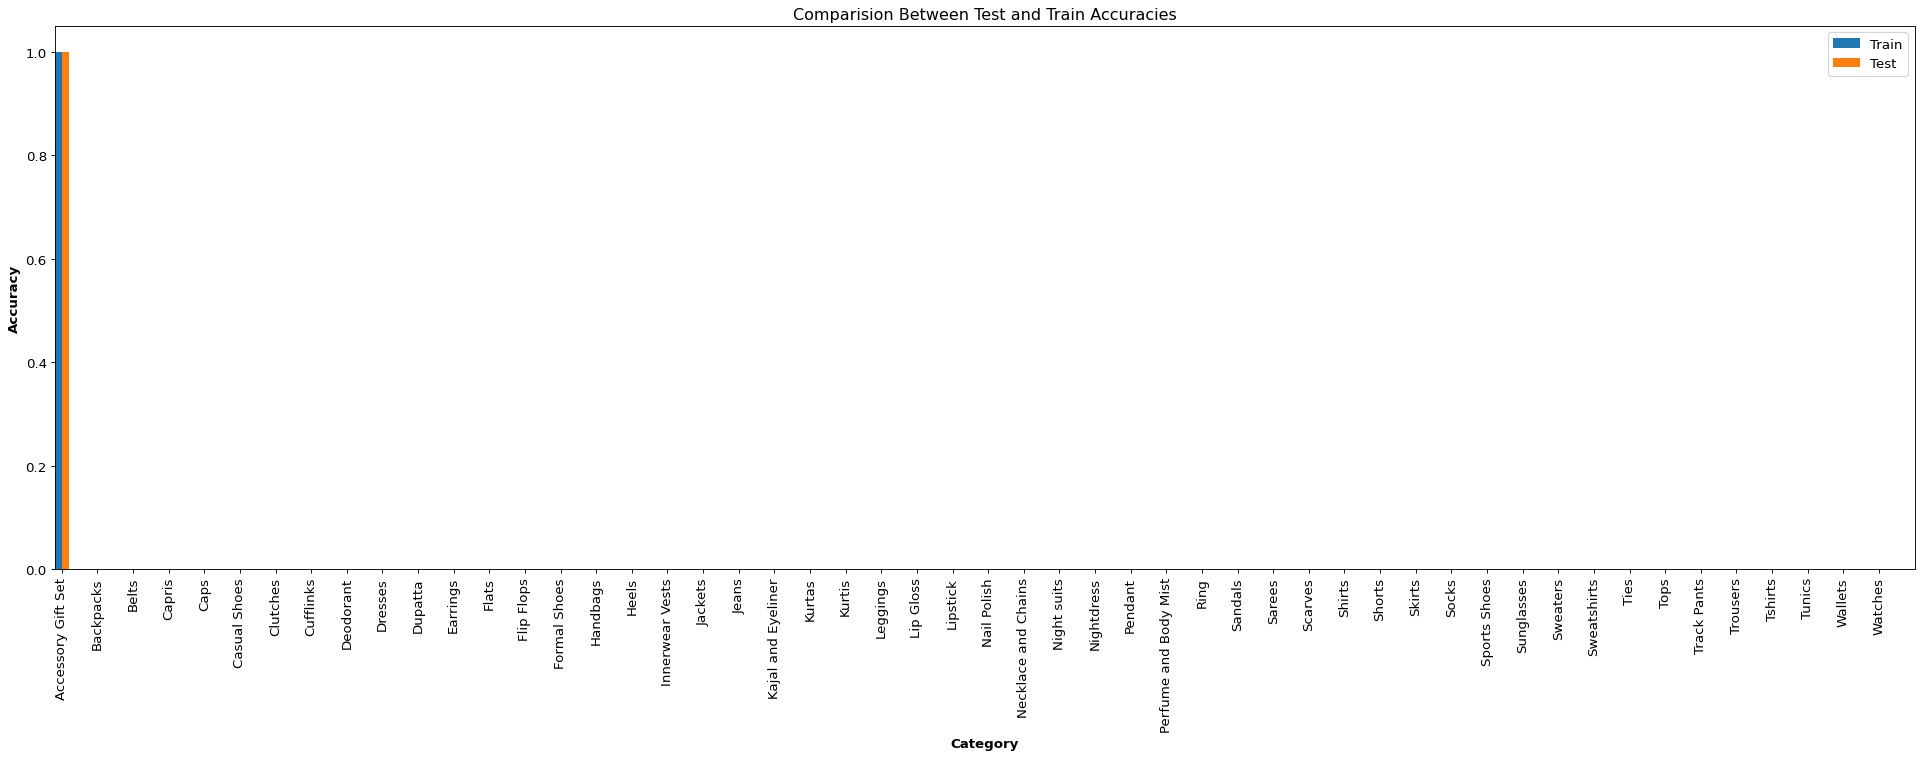

In [ ]:
analyse(model, train_loader, test_loader, classes)

<div lang="fa" dir="rtl">
<p>
همانطور که در نمودار مشخص است، تنها کلاسی که درست تشخیص داده شده، کلاس اول یعنی Accessory Gift Set
می باشد.

بعبارتی همه ی تشخیص ها برای این کلاس بوده و نتیجه می گیریم که این مدل اصلا مدل مناسبی نبوده است.

حال تعداد لایه های شبکه را بیشتر می کنیم.

همچنین تعداد نورون ها در هر لایه را نیز افزایش می دهیم.
</p>
</div>

epoch 1, train_loss: nan, time elapsed: 21.160587 seconds
epoch 2, train_loss: nan, time elapsed: 21.050842 seconds
epoch 3, train_loss: nan, time elapsed: 20.991186 seconds
epoch 4, train_loss: nan, time elapsed: 21.012444 seconds
epoch 5, train_loss: nan, time elapsed: 20.975528 seconds
epoch 6, train_loss: nan, time elapsed: 20.970794 seconds
epoch 7, train_loss: nan, time elapsed: 20.935576 seconds
epoch 8, train_loss: nan, time elapsed: 20.946528 seconds
epoch 9, train_loss: nan, time elapsed: 21.000296 seconds
epoch 10, train_loss: nan, time elapsed: 20.861566 seconds
Could not plot for nan losses.
total training time: 3.498 minutes
Train Accuracy: 0.29866774052820566%
Test Accuracy: 0.2953020134228188%


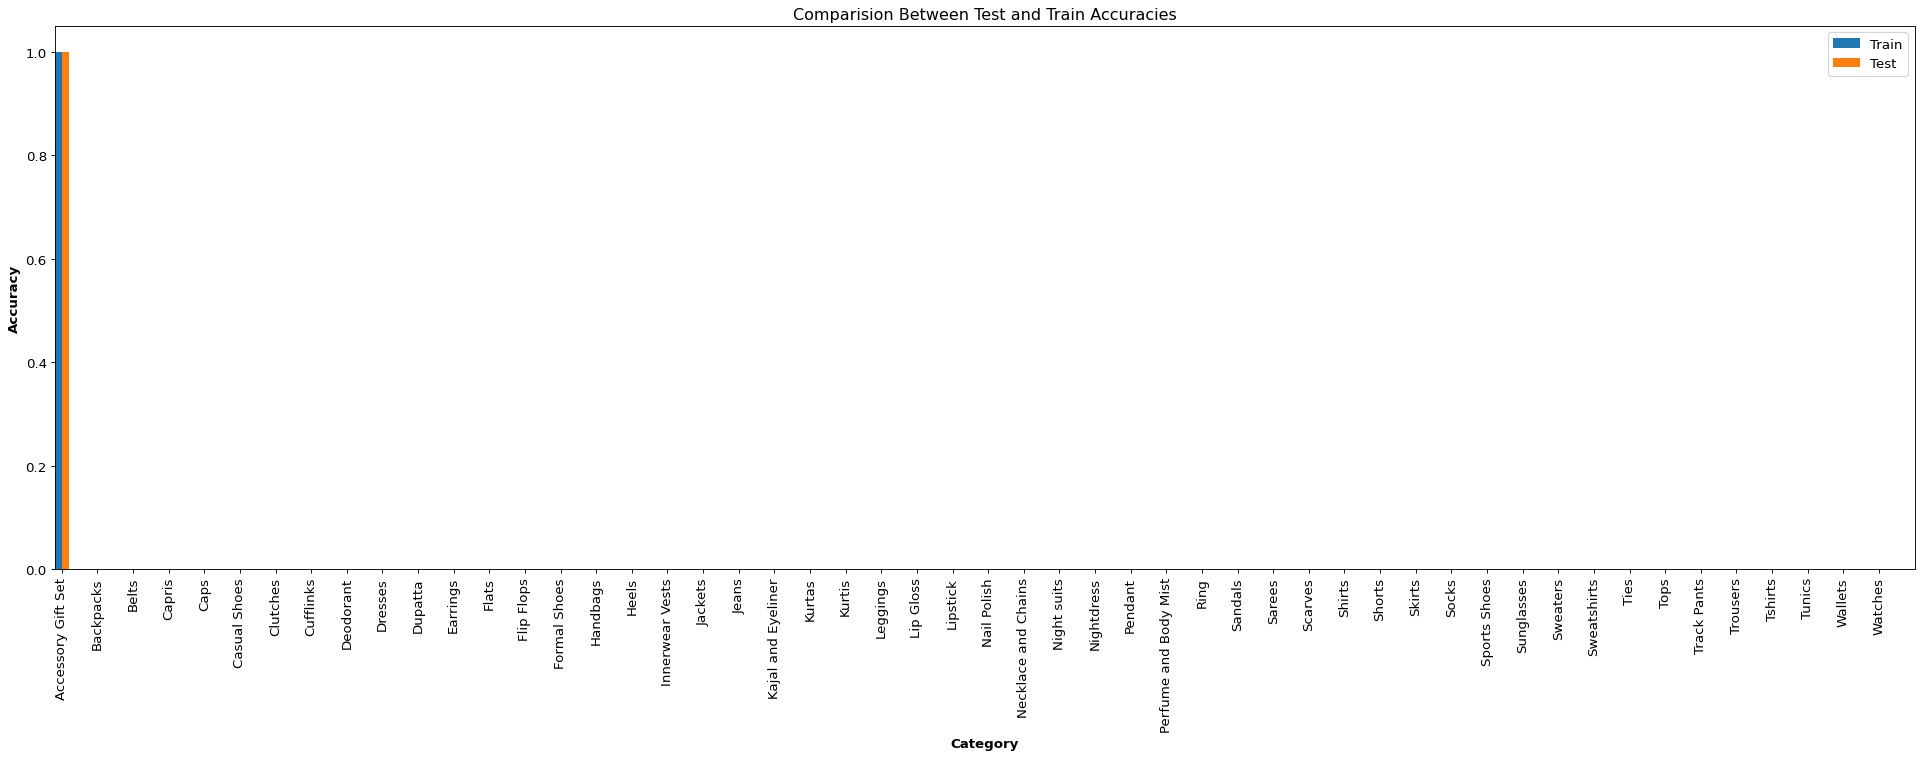

In [ ]:
new_model = Model(image_size, [10000, 5000, 1000, 200] , len(classes), F.relu)
new_model = new_model.to(device)
optimizer = torch.optim.SGD(new_model.parameters(), lr=learning_rate)
fit(new_model, train_loader, device, criterion, optimizer, num_epochs=10)
analyse(new_model, train_loader, test_loader, classes)

<div lang="fa" dir="rtl">
<p>
همانطور که مشاهده می کنیم افزایش تعداد لایه ها و نورون ها تاثیری در نتیجه نداشت.

دلیل این امر این است که چون train loss
بسیار زیاد می باشد، با افزایش تعداد پارامترهای قابل آموزش در شبکه، علی رغم انتظار کاهش loss، این مقدار در مجموع بسیار زیاد خواهد شد و باز هم به نتیجه ای نخواهیم رسید.

اکنون تلاش می کنیم تا تعدا نورون ها را کمتر کنیم تا این مشکل برطرف شود.
</p>
</div>

epoch 1, train_loss: 3.940, time elapsed: 4.406534 seconds
epoch 2, train_loss: 3.826, time elapsed: 3.549183 seconds
epoch 3, train_loss: 3.744, time elapsed: 3.506476 seconds
epoch 4, train_loss: 3.680, time elapsed: 3.555292 seconds
epoch 5, train_loss: 3.631, time elapsed: 3.546718 seconds
epoch 6, train_loss: 3.595, time elapsed: 3.491334 seconds
epoch 7, train_loss: 3.567, time elapsed: 3.523722 seconds
epoch 8, train_loss: 3.546, time elapsed: 3.486296 seconds
epoch 9, train_loss: 3.530, time elapsed: 3.467481 seconds
epoch 10, train_loss: 3.517, time elapsed: 3.520769 seconds


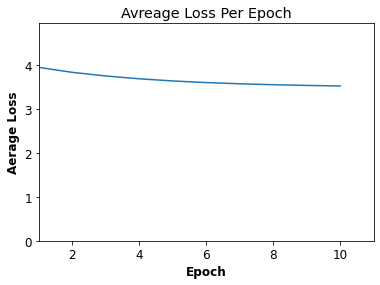

total training time: 0.601 minutes
Train Accuracy: 9.48689553340716%
Test Accuracy: 9.48993288590604%


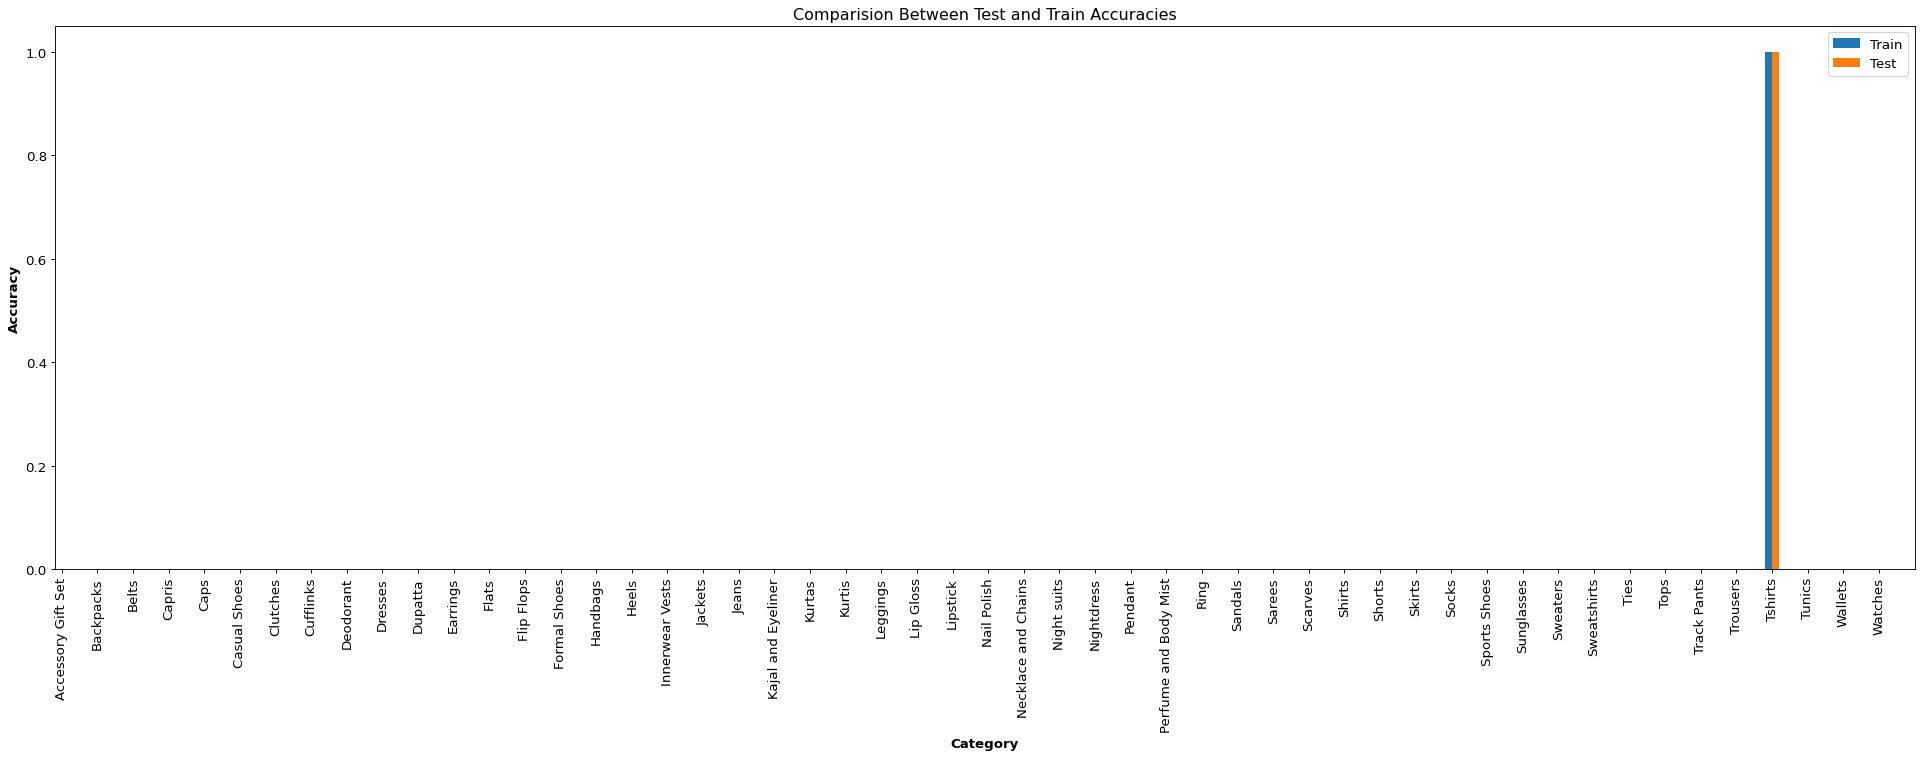

In [ ]:
new_model = Model(image_size, [1000, 500, 10] , len(classes), F.relu)
new_model = new_model.to(device)
optimizer = torch.optim.SGD(new_model.parameters(), lr=learning_rate)
fit(new_model, train_loader, device, criterion, optimizer, num_epochs=10)
analyse(new_model, train_loader, test_loader, classes)

<div lang="fa" dir="rtl">
<p>
همانطور که میبینیم مشکل nan بودن loss ها
برطرف شد اما بدلیل پایین بودن تعداد پارامترهای قابل آموزش، بهبودی در مدل حاصل نشد.

بنابراین فعلا از همان تعداد لایه ها و نورون های ثانویه برای آموزش شبکه ی خود استفاده می کنیم.
</p>
</div>

<div lang="fa" dir="rtl">
<h2>
بخش چهارم
</h2>
<p>
در این بخش محدوده پیکسل های تصاویر را از 0 تا 255 به بازه ی 0 تا 1 خواهیم برد.

برای این کار از scaled dataset
ای که در ابتدای کار ایجاد کردیم استفاده می کنیم.

این dataset از
تبدیل ToTensor
که برای pytorch
است استفاده کرده که در آن نگاشت به بازه ی 0 تا 1 انجام می شود.
</p>
</div>

epoch 1, train_loss: 3.429, time elapsed: 21.519602 seconds
epoch 2, train_loss: 2.704, time elapsed: 21.456167 seconds
epoch 3, train_loss: 2.272, time elapsed: 21.425333 seconds
epoch 4, train_loss: 1.942, time elapsed: 21.51738 seconds
epoch 5, train_loss: 1.753, time elapsed: 21.520168 seconds
epoch 6, train_loss: 1.625, time elapsed: 21.476832 seconds
epoch 7, train_loss: 1.528, time elapsed: 21.507933 seconds
epoch 8, train_loss: 1.454, time elapsed: 21.4066 seconds
epoch 9, train_loss: 1.394, time elapsed: 21.378383 seconds
epoch 10, train_loss: 1.345, time elapsed: 21.440632 seconds


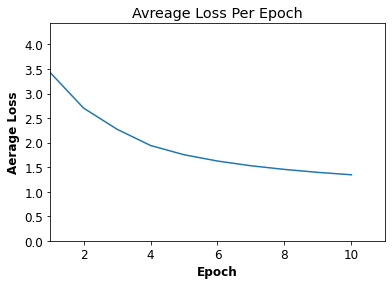

total training time: 3.577 minutes
Train Accuracy: 56.15960267123058%
Test Accuracy: 55.93288590604027%


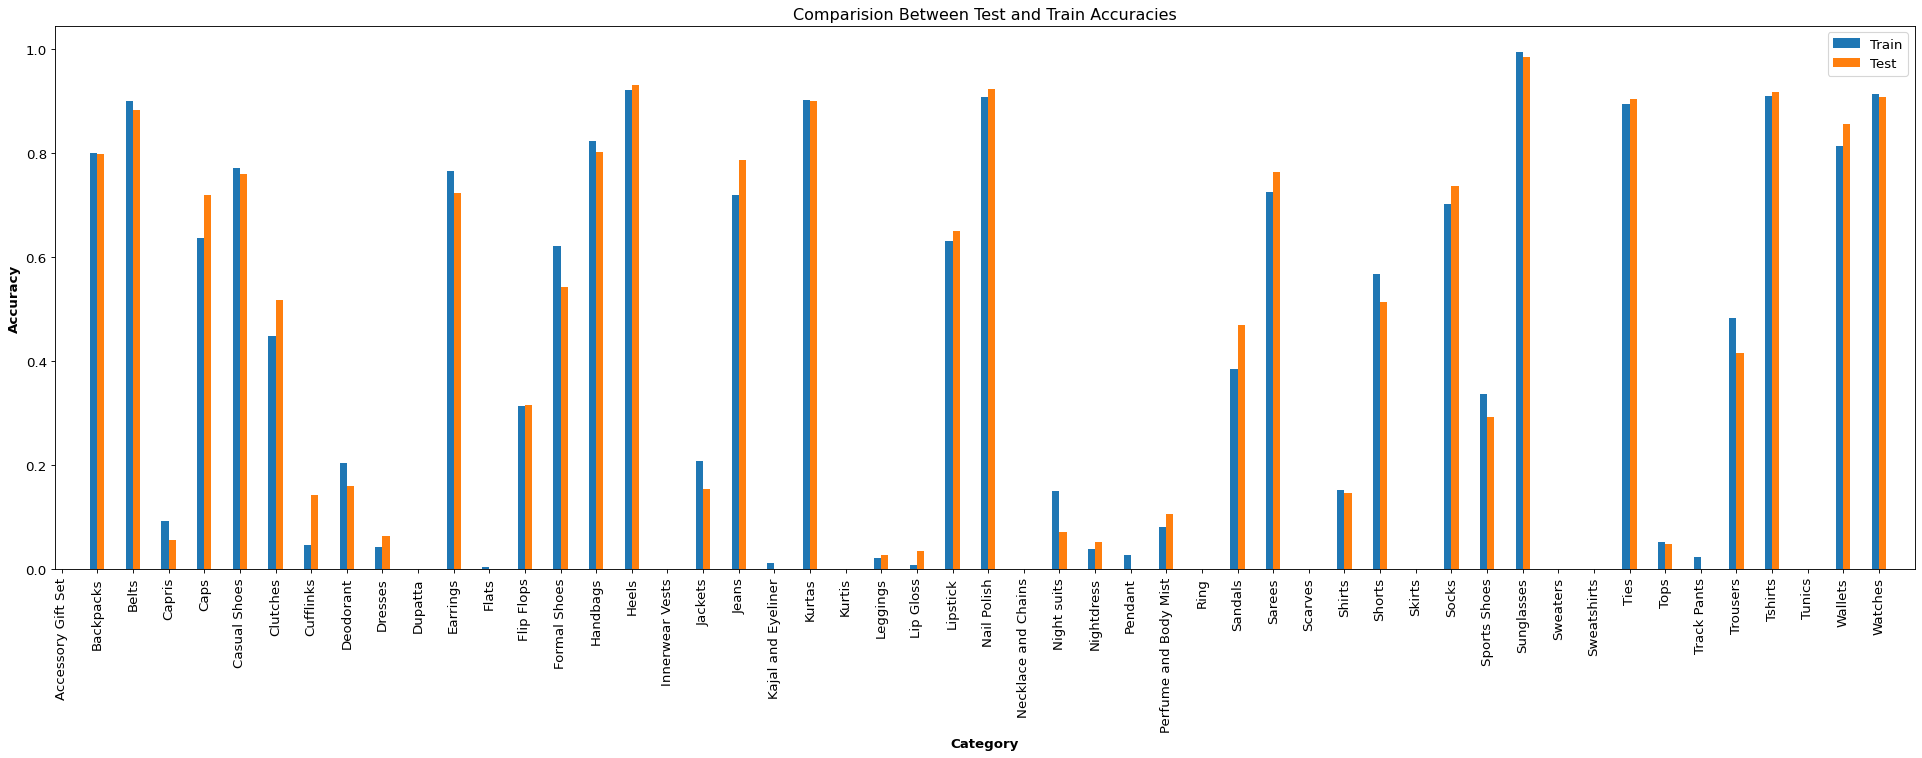

In [ ]:
model = Model(image_size, [10000, 5000, 1000, 200] , len(classes), F.relu)
model = model.to(device)
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)
fit(model, scaled_train_loader, device, criterion, optimizer, num_epochs=10)
analyse(model, scaled_train_loader, scaled_test_loader, classes)

<div lang="fa" dir="rtl">
<p>
همانطور که مشاهده می کنیم مدل پیشرفت بسیار زیادی کرد و مقدار train loss
در epoch ها بشدت کاهش یافت.

همچنین دقت مدل به 55 درصد رسید که پیشرفت بسیار خوبی به حساب می آید.

دلیل این پیشرفت این است که تا پیش از این تصاویر را scale
نمی کردیم و مقدار activation function
برای آن بسیار زیاد شده و در نتیجه مقدار loss
به سمت بی نهایت می رفت.

اما اکنون تصاویر را نرمالایز کردیم و این عملکرد مدل را به مراتب بهبود می بخشد.
</p>
</div>

<div lang="fa" dir="rtl">
<h2>
بخش پنجم
</h2>
<h3>
الف
</h3>
<p>
با استفاده از تابع apply می توانیم مقادیر اولیه ی وزن های شبکه را تغییر دهیم.

این کار را بصورت زیر انجام می دهیم:
</p>
</div>

epoch 1, train_loss: 3.896, time elapsed: 20.547213 seconds
epoch 2, train_loss: 3.798, time elapsed: 20.608079 seconds
epoch 3, train_loss: 3.720, time elapsed: 20.456429 seconds
epoch 4, train_loss: 3.661, time elapsed: 20.475909 seconds
epoch 5, train_loss: 3.616, time elapsed: 20.450046 seconds
epoch 6, train_loss: 3.582, time elapsed: 20.410466 seconds
epoch 7, train_loss: 3.557, time elapsed: 20.472087 seconds
epoch 8, train_loss: 3.538, time elapsed: 20.406071 seconds
epoch 9, train_loss: 3.524, time elapsed: 20.398028 seconds
epoch 10, train_loss: 3.513, time elapsed: 20.838369 seconds


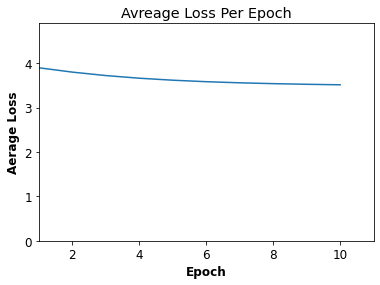

total training time: 3.418 minutes
Train Accuracy: 9.48689553340716%
Test Accuracy: 9.48993288590604%


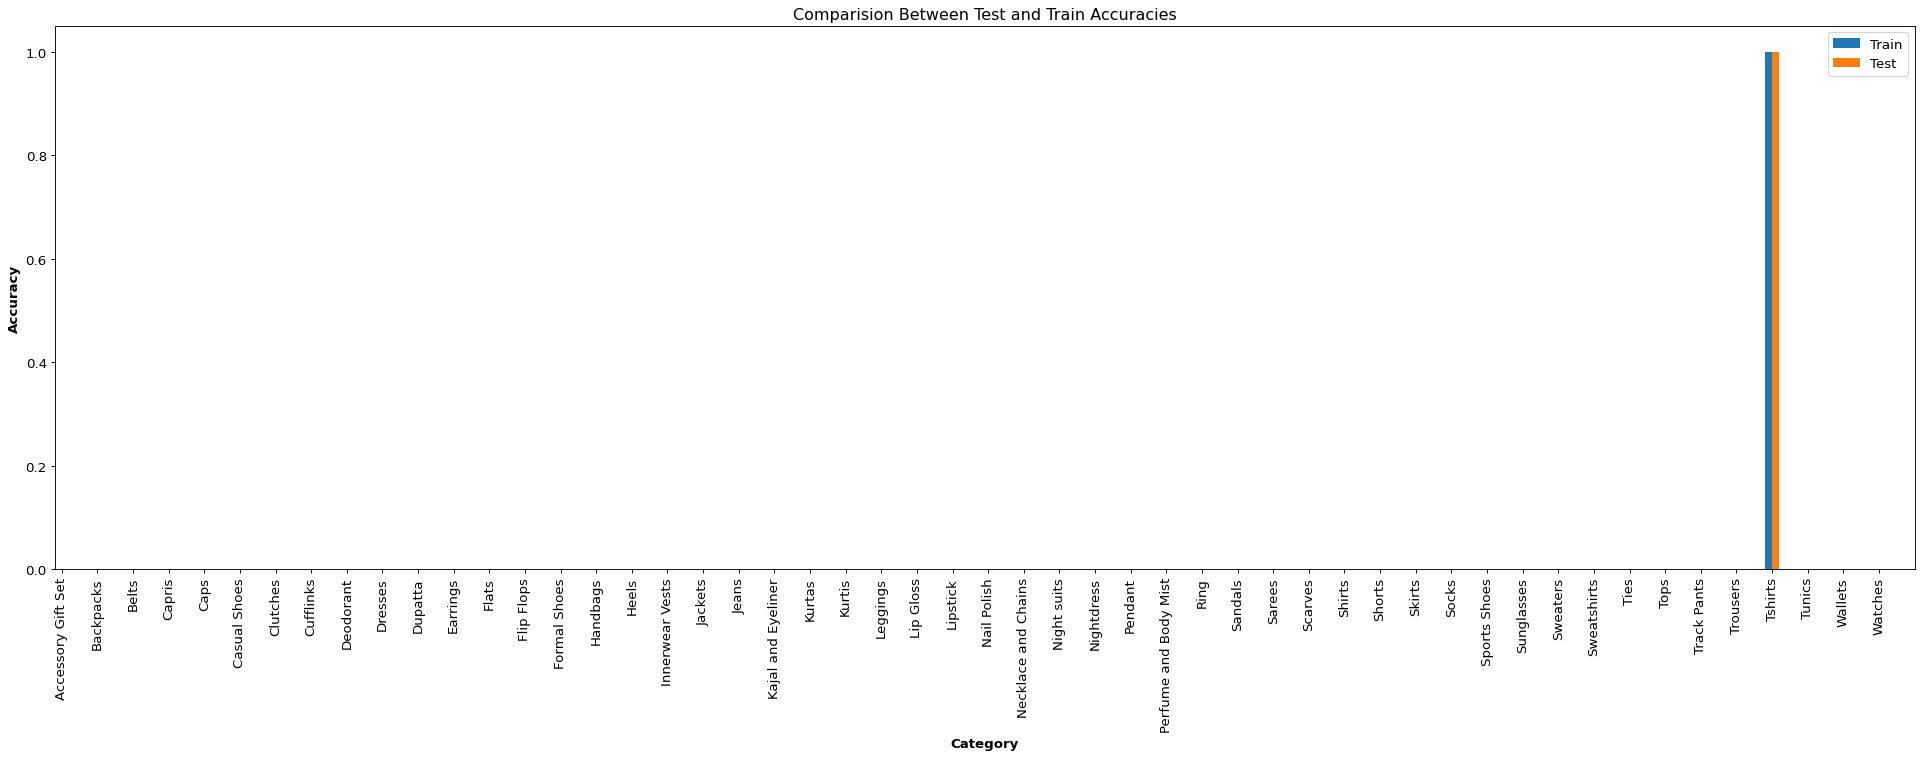

In [ ]:
model = Model(image_size, [10000, 5000, 1000, 200] , len(classes), F.relu)

def init_normal(m):
    if type(m) == nn.Linear:
        m.weight.data.fill_(0)
        m.bias.data.fill_(0)

model.apply(init_normal)
model = model.to(device)
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)
fit(model, scaled_train_loader, device, criterion, optimizer, num_epochs=10)
analyse(model, scaled_train_loader, scaled_test_loader, classes)

<div lang="fa" dir="rtl">
<p>
هنگامی که مقدار اولیه ی تمامی وزن ها را برابر صفر می گذاریم، تمامی نورون ها در هر لایه خروجی یکسانی تولید می کنند.

بنابراین تصمیم گیری برای اینکه کدام وزن ها باید تغییر پیدا کنند را سخت می کند و مدل نمی تواند به خوبی به هدف نزدیک شود.

در نتیجه این روش توصیه نمی شود.
</p>

<h3>
ب
</h3>
<p>
بهترین مقدار بعنوان مقدار اولیه ی وزن ها، مقادیری نزدیک به صفر (و نه خود صفر) می باشد.

برای مثال می توان وزن ها را به روش زیر مقدار اولیه دهی کرد.

در این روش وزن ها توزیعی حول صفر دارند و مقادیر آن ها بسیار کوچک است.

همچنین بهترین حالت برای مقادیر بایاس، مقدار صفر می باشد.
</p>
</div>

In [ ]:
def init_normal(m):
    if type(m) == nn.Linear:
        n = m.in_features
        y = 1.0/np.sqrt(n)
        m.weight.data.uniform_(-y, y)
        m.bias.data.fill_(0)

<div lang="fa" dir="rtl">
<h2>
بخش ششم
</h2>
<h3>
الف
</h3>
<p>
حال مقادیر مختلفی را بعنوان learning rate
امتحان کرده و شبکه را بر اساس این rate های مختلف آموزش می دهیم.

پس از پایان هر دور آموزش، دقت و نمودار دقت مدل را رسم کرده و train loss
را برای هرکدام بررسی میکنیم تا در نهایت بهترین learning rate را انتخاب کنیم.
</p>
</div>

Learning Rate: 0.0005
epoch 1, train_loss: 3.932, time elapsed: 21.642007 seconds
epoch 2, train_loss: 3.866, time elapsed: 21.567571 seconds
epoch 3, train_loss: 3.731, time elapsed: 21.527739 seconds
epoch 4, train_loss: 3.552, time elapsed: 21.604008 seconds
epoch 5, train_loss: 3.482, time elapsed: 21.531994 seconds
epoch 6, train_loss: 3.459, time elapsed: 21.678989 seconds
epoch 7, train_loss: 3.446, time elapsed: 21.545762 seconds
epoch 8, train_loss: 3.436, time elapsed: 21.462718 seconds
epoch 9, train_loss: 3.427, time elapsed: 21.454146 seconds
epoch 10, train_loss: 3.417, time elapsed: 21.451925 seconds


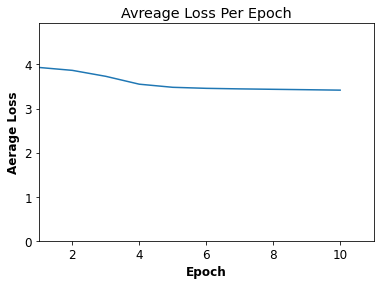

total training time: 3.591 minutes
Train Accuracy: 13.570925198832176%
Test Accuracy: 13.395973154362416%


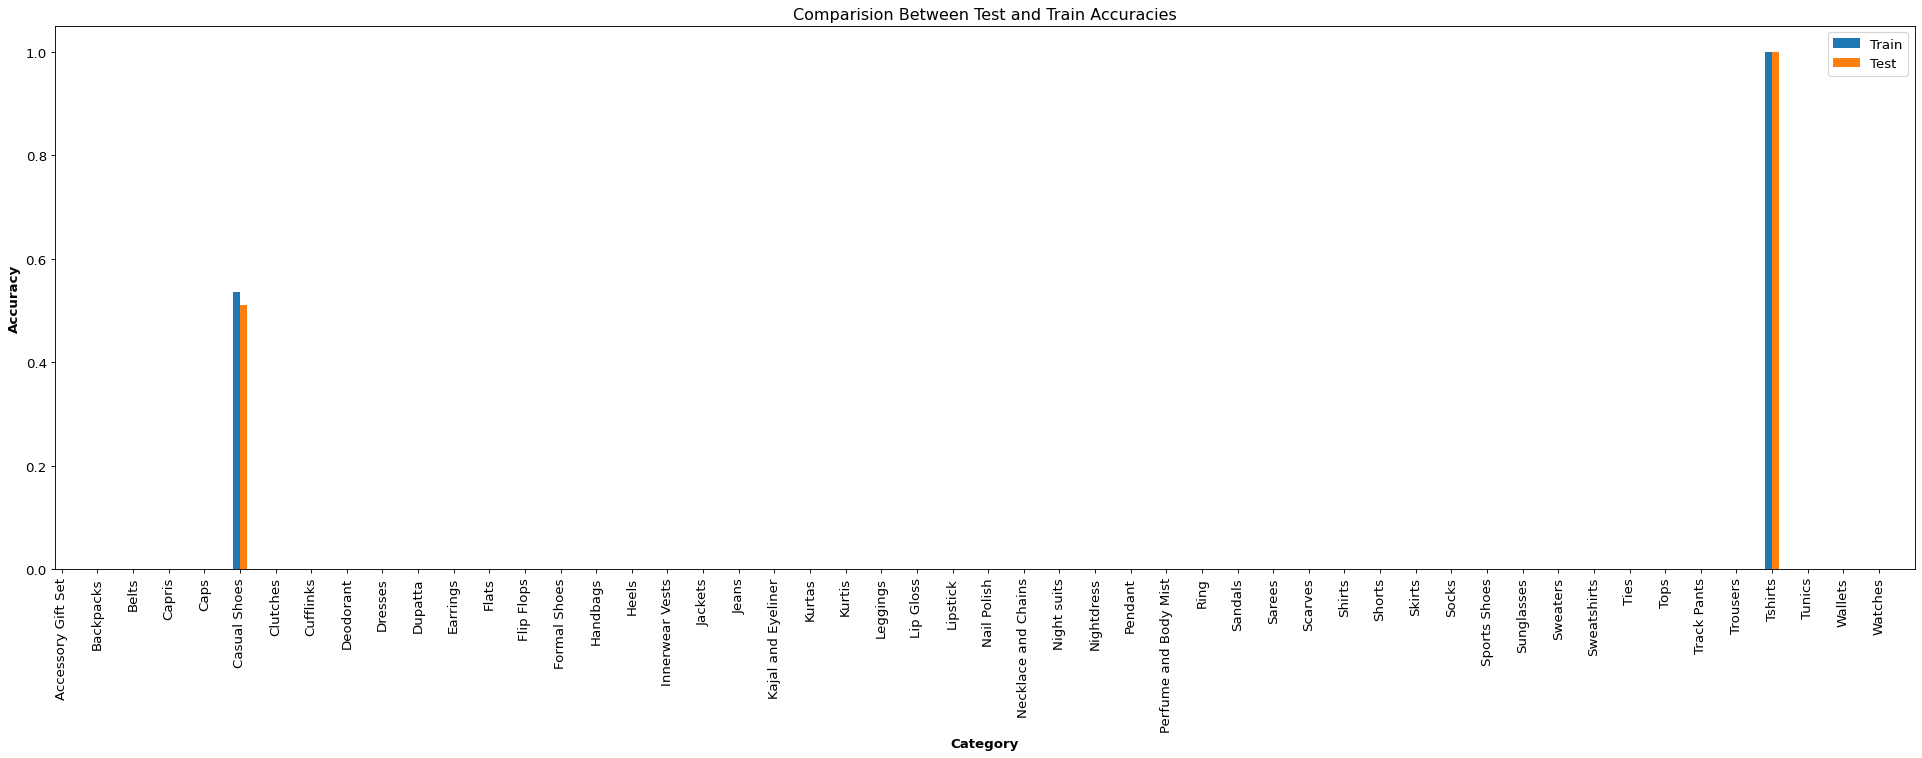

Learning Rate: 0.001
epoch 1, train_loss: 3.904, time elapsed: 21.472087 seconds
epoch 2, train_loss: 3.683, time elapsed: 21.459572 seconds
epoch 3, train_loss: 3.474, time elapsed: 21.510471 seconds
epoch 4, train_loss: 3.442, time elapsed: 21.411268 seconds
epoch 5, train_loss: 3.421, time elapsed: 21.446084 seconds
epoch 6, train_loss: 3.395, time elapsed: 21.415627 seconds
epoch 7, train_loss: 3.354, time elapsed: 21.478194 seconds
epoch 8, train_loss: 3.280, time elapsed: 21.380451 seconds
epoch 9, train_loss: 3.163, time elapsed: 21.417477 seconds
epoch 10, train_loss: 3.032, time elapsed: 21.496147 seconds


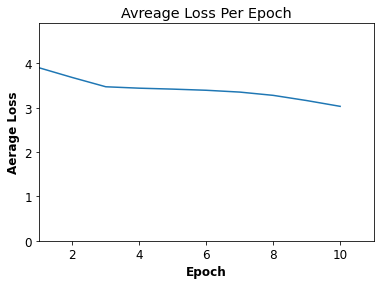

total training time: 3.575 minutes
Train Accuracy: 22.17859659720125%
Test Accuracy: 22.0%


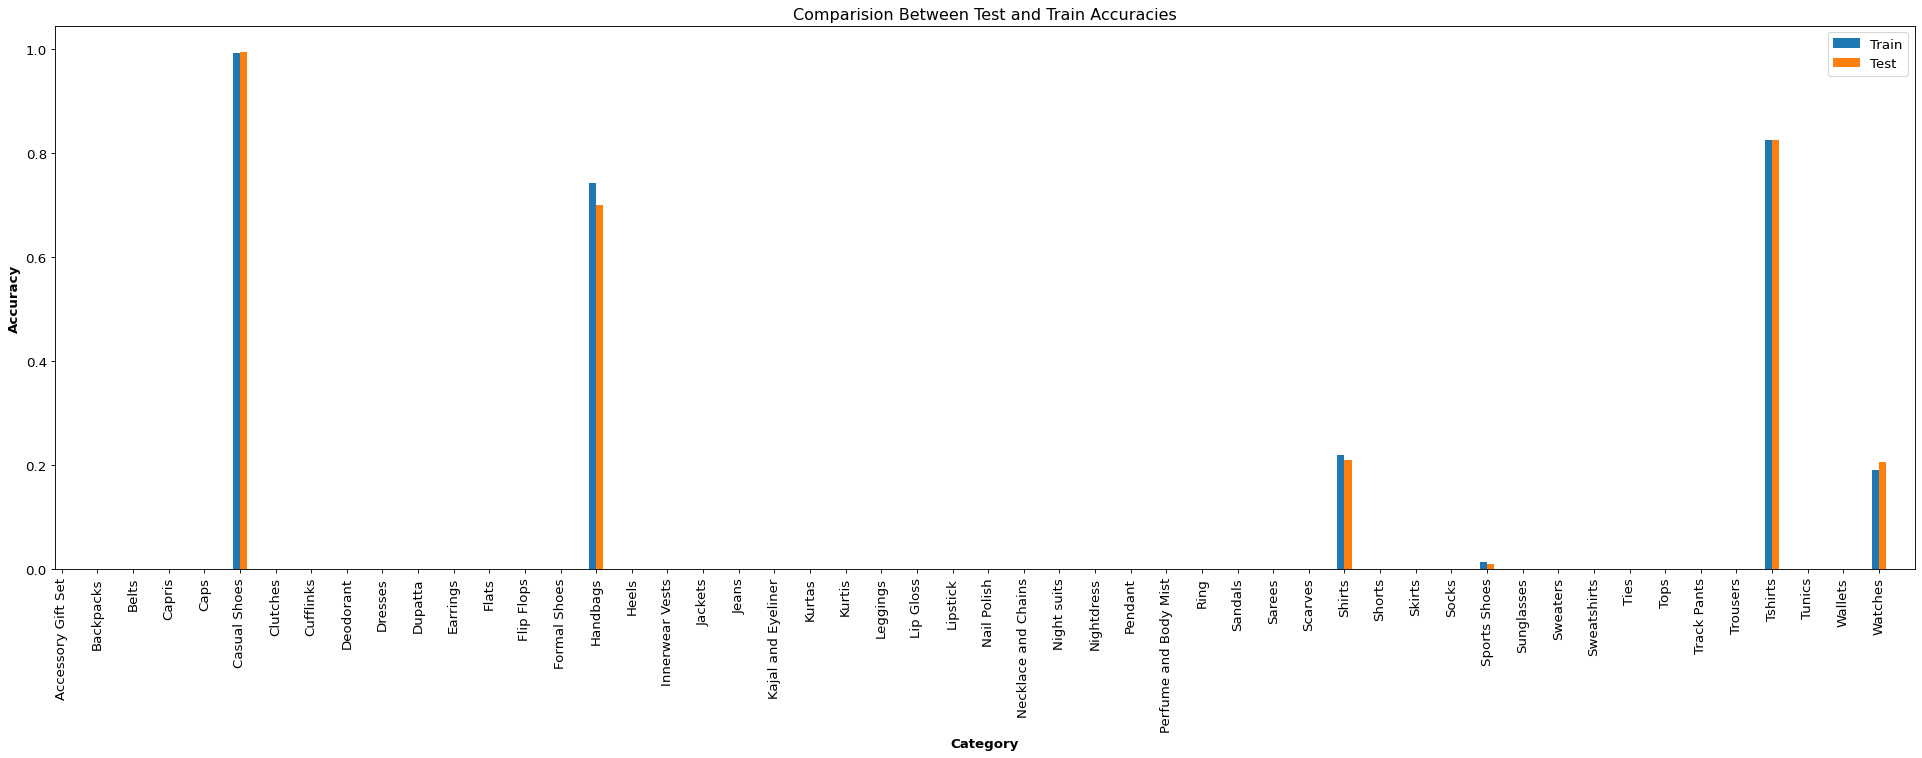

Learning Rate: 0.005
epoch 1, train_loss: 3.585, time elapsed: 21.415569 seconds
epoch 2, train_loss: 3.250, time elapsed: 21.386289 seconds
epoch 3, train_loss: 2.804, time elapsed: 21.357137 seconds
epoch 4, train_loss: 2.524, time elapsed: 21.387517 seconds
epoch 5, train_loss: 2.307, time elapsed: 21.405781 seconds
epoch 6, train_loss: 2.114, time elapsed: 21.370231 seconds
epoch 7, train_loss: 1.941, time elapsed: 21.447221 seconds
epoch 8, train_loss: 1.798, time elapsed: 21.331029 seconds
epoch 9, train_loss: 1.697, time elapsed: 21.418158 seconds
epoch 10, train_loss: 1.622, time elapsed: 21.419373 seconds


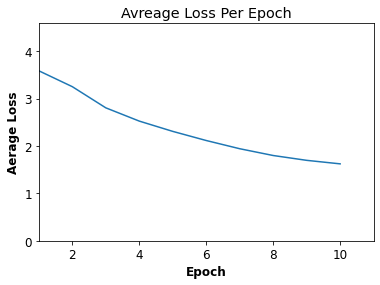

total training time: 3.566 minutes
Train Accuracy: 45.92435987784825%
Test Accuracy: 45.97315436241611%


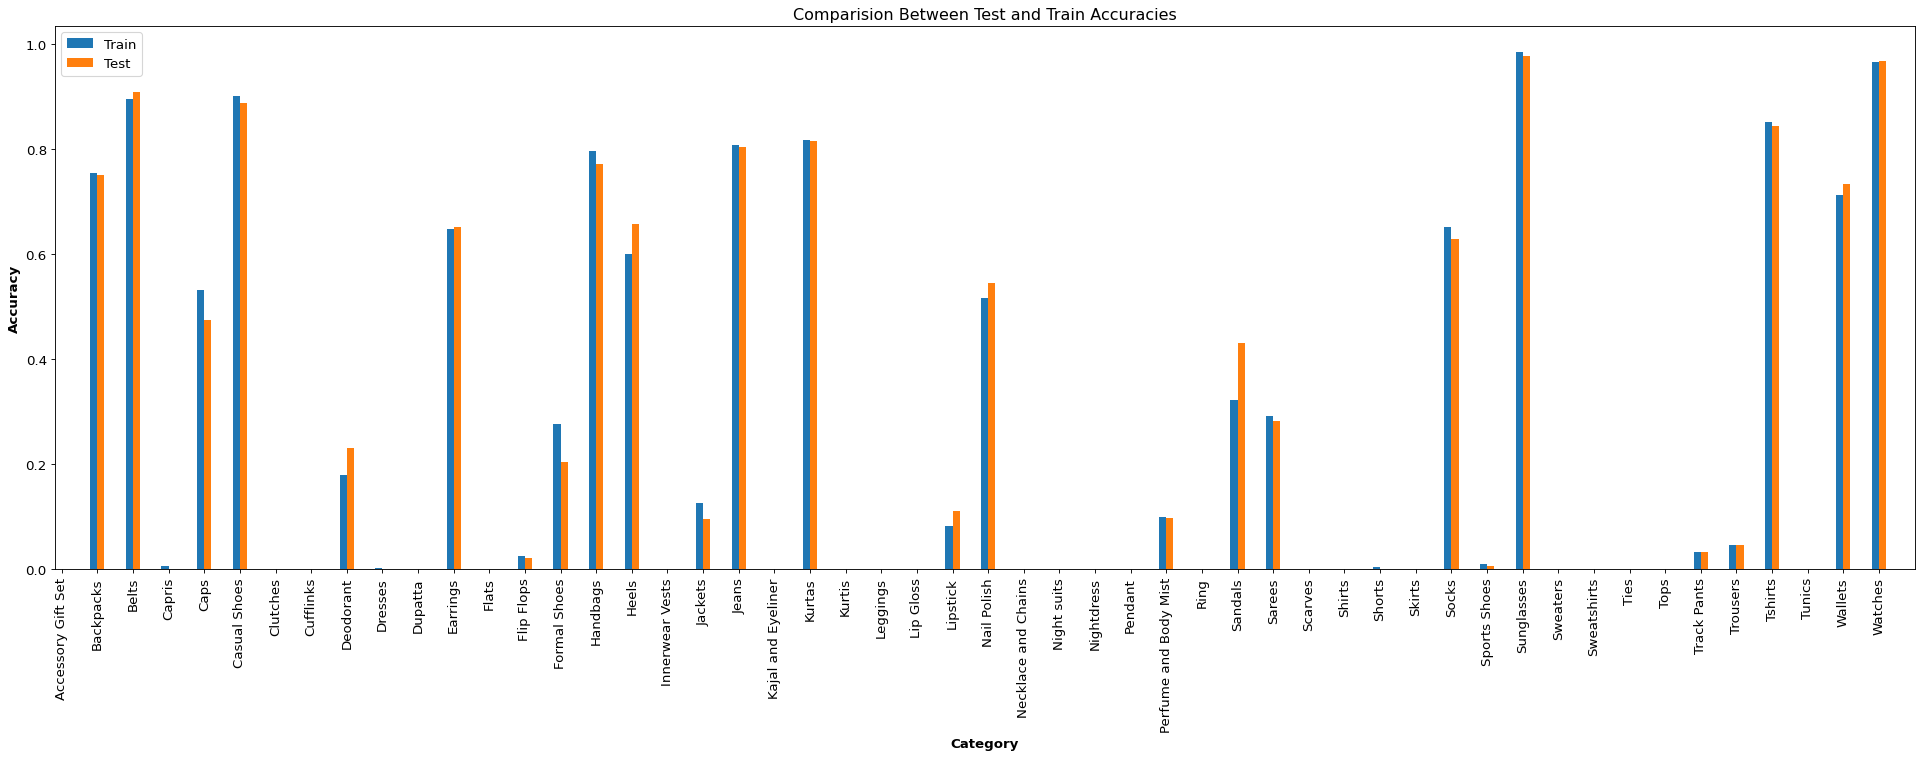

Learning Rate: 0.01
epoch 1, train_loss: 3.444, time elapsed: 21.358063 seconds
epoch 2, train_loss: 2.767, time elapsed: 21.358464 seconds
epoch 3, train_loss: 2.329, time elapsed: 21.417975 seconds
epoch 4, train_loss: 1.987, time elapsed: 21.297206 seconds
epoch 5, train_loss: 1.782, time elapsed: 21.368471 seconds
epoch 6, train_loss: 1.657, time elapsed: 21.41808 seconds
epoch 7, train_loss: 1.552, time elapsed: 21.460003 seconds
epoch 8, train_loss: 1.467, time elapsed: 21.581831 seconds
epoch 9, train_loss: 1.398, time elapsed: 21.609309 seconds
epoch 10, train_loss: 1.344, time elapsed: 21.635262 seconds


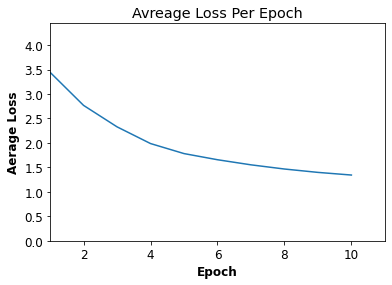

total training time: 3.575 minutes
Train Accuracy: 57.250243296754924%
Test Accuracy: 56.630872483221474%


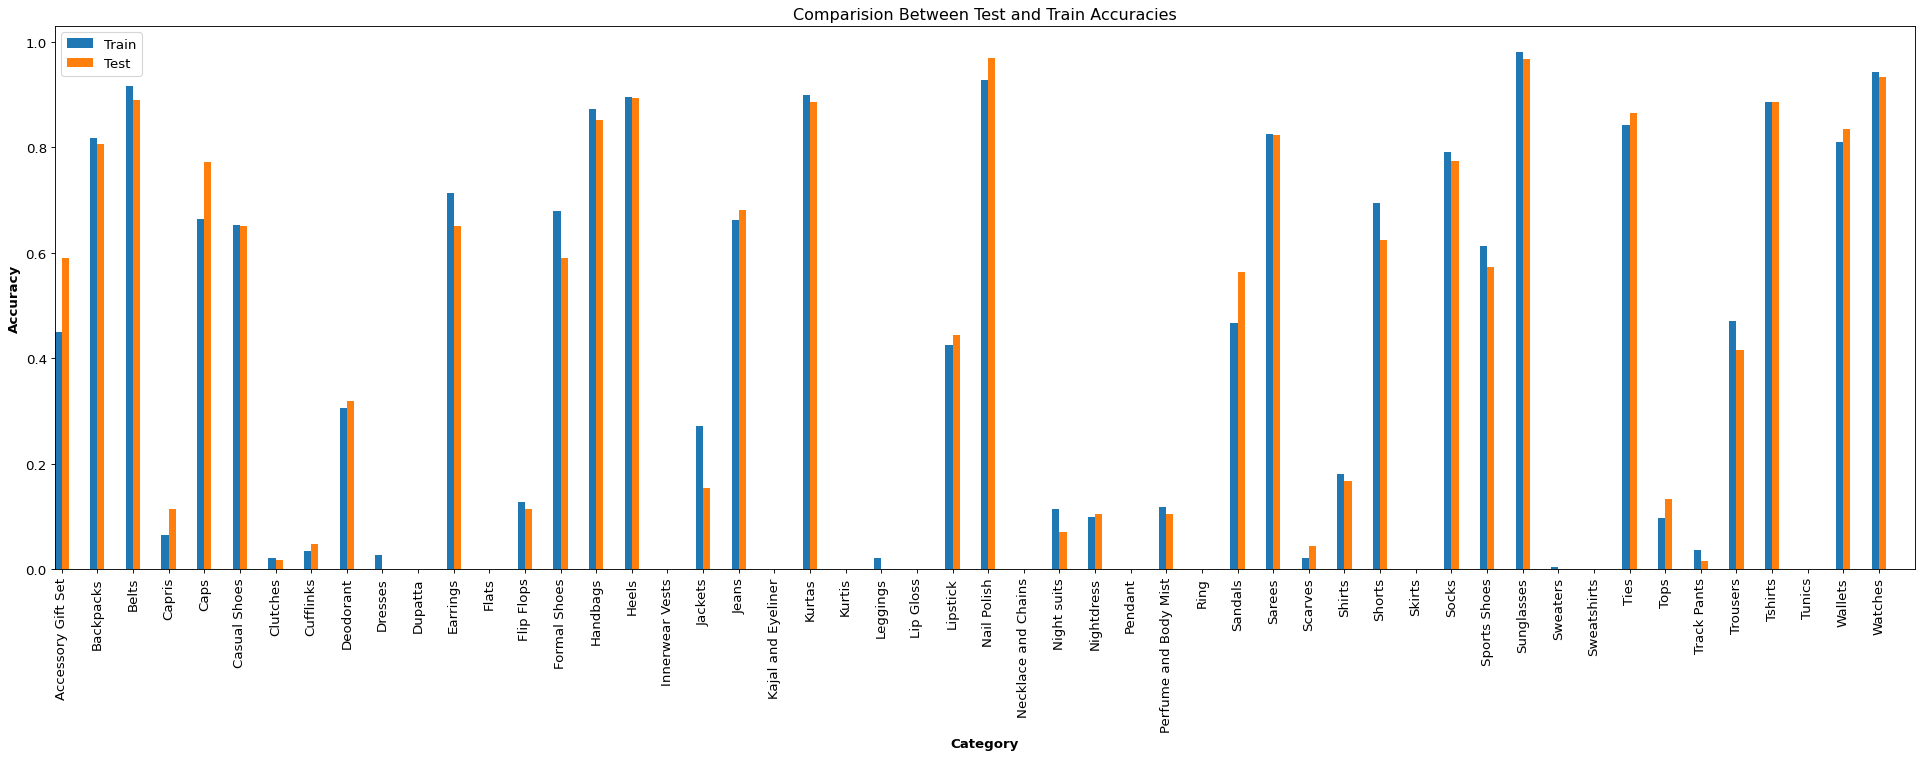

Learning Rate: 0.05
epoch 1, train_loss: 2.839, time elapsed: 21.524919 seconds
epoch 2, train_loss: 2.023, time elapsed: 21.467068 seconds
epoch 3, train_loss: 1.710, time elapsed: 21.53426 seconds
epoch 4, train_loss: 1.474, time elapsed: 21.436999 seconds
epoch 5, train_loss: 1.353, time elapsed: 21.511152 seconds
epoch 6, train_loss: 1.256, time elapsed: 21.474744 seconds
epoch 7, train_loss: 1.192, time elapsed: 21.565589 seconds
epoch 8, train_loss: 1.143, time elapsed: 21.385492 seconds
epoch 9, train_loss: 1.078, time elapsed: 21.418861 seconds
epoch 10, train_loss: 1.030, time elapsed: 21.376846 seconds


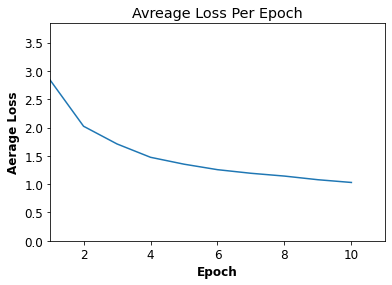

total training time: 3.578 minutes
Train Accuracy: 64.98875801201383%
Test Accuracy: 64.08053691275168%


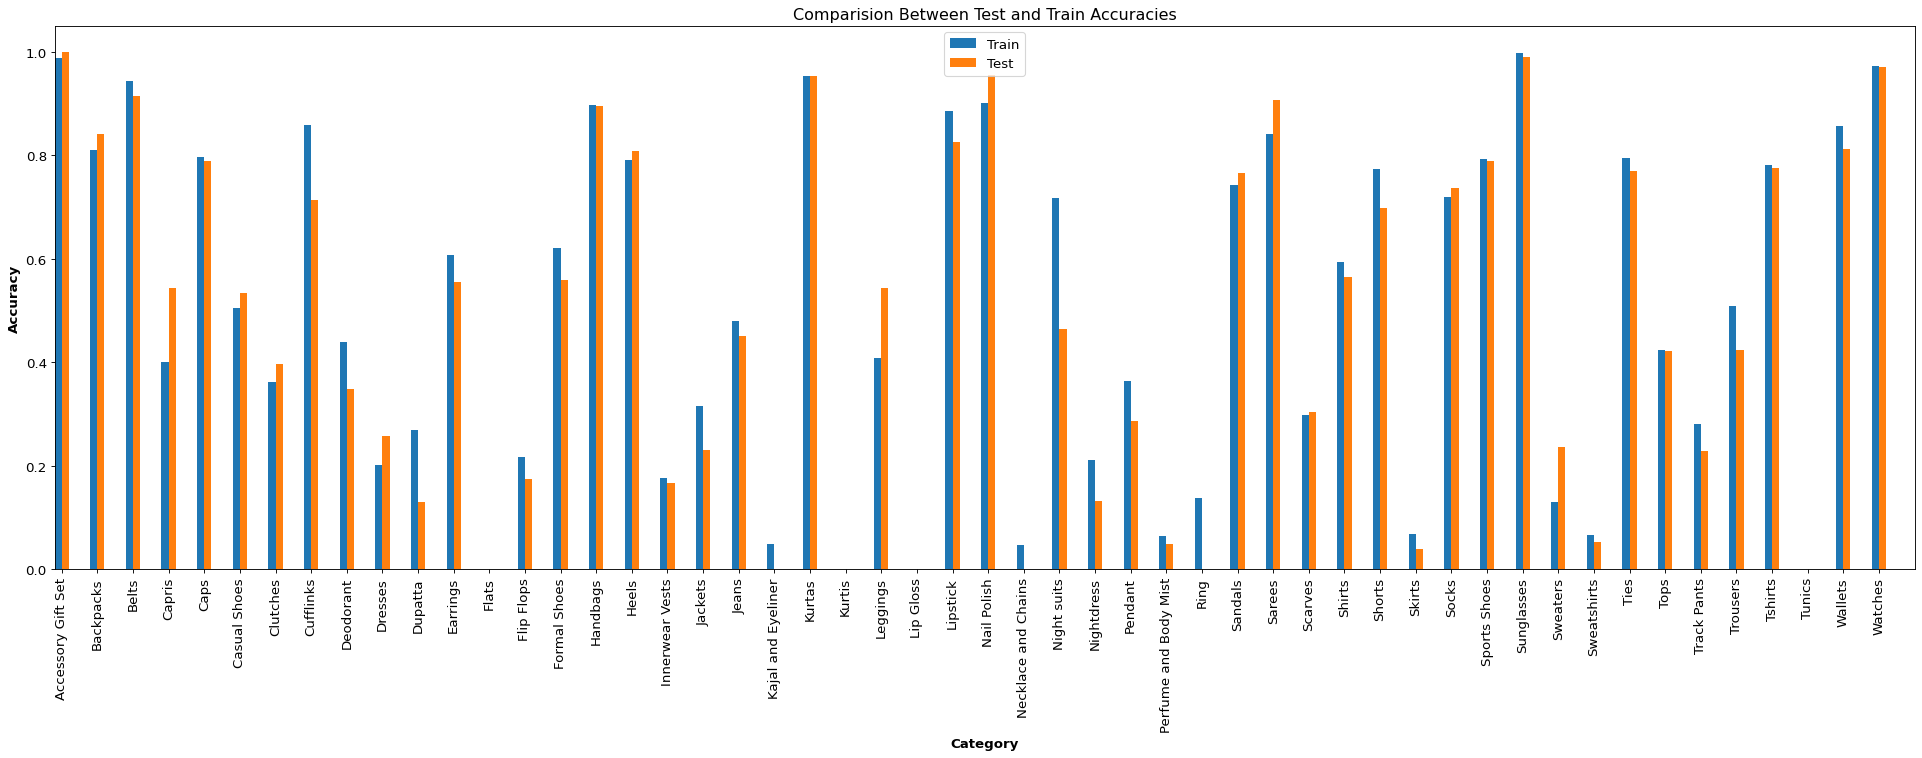

Learning Rate: 0.075
epoch 1, train_loss: 2.932, time elapsed: 21.418868 seconds
epoch 2, train_loss: 2.113, time elapsed: 21.320691 seconds
epoch 3, train_loss: 1.778, time elapsed: 21.332938 seconds
epoch 4, train_loss: 1.533, time elapsed: 21.328109 seconds
epoch 5, train_loss: 1.390, time elapsed: 21.301032 seconds
epoch 6, train_loss: 1.295, time elapsed: 21.300622 seconds
epoch 7, train_loss: 1.209, time elapsed: 21.342062 seconds
epoch 8, train_loss: 1.146, time elapsed: 21.424587 seconds
epoch 9, train_loss: 1.083, time elapsed: 21.371897 seconds
epoch 10, train_loss: 1.031, time elapsed: 21.45249 seconds


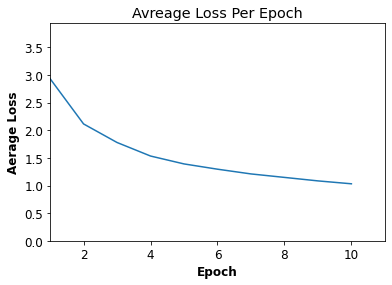

total training time: 3.560 minutes
Train Accuracy: 66.12302426255914%
Test Accuracy: 65.2751677852349%


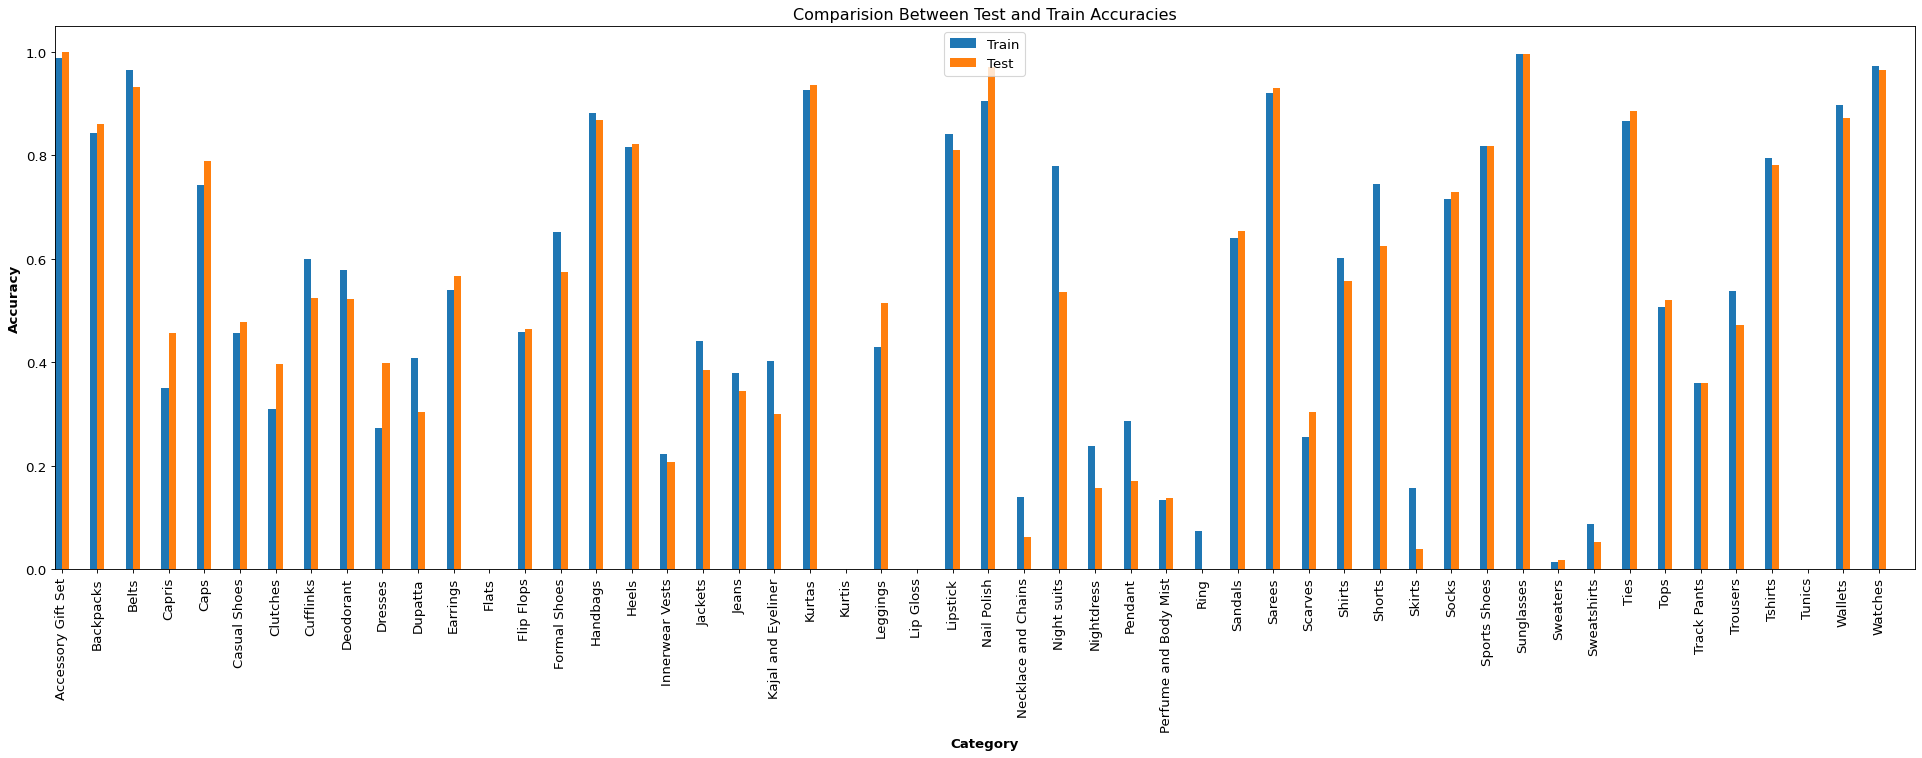

Learning Rate: 0.1
epoch 1, train_loss: 3.123, time elapsed: 21.602137 seconds
epoch 2, train_loss: 2.401, time elapsed: 21.331731 seconds
epoch 3, train_loss: 1.942, time elapsed: 21.279087 seconds
epoch 4, train_loss: 1.671, time elapsed: 21.225286 seconds
epoch 5, train_loss: 1.491, time elapsed: 21.237734 seconds
epoch 6, train_loss: 1.360, time elapsed: 21.356673 seconds
epoch 7, train_loss: 1.281, time elapsed: 21.264889 seconds
epoch 8, train_loss: 1.208, time elapsed: 21.253556 seconds
epoch 9, train_loss: 1.141, time elapsed: 21.289183 seconds
epoch 10, train_loss: 1.081, time elapsed: 21.263727 seconds


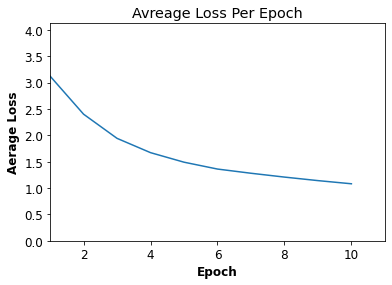

total training time: 3.552 minutes
Train Accuracy: 65.16997214671633%
Test Accuracy: 64.08053691275168%


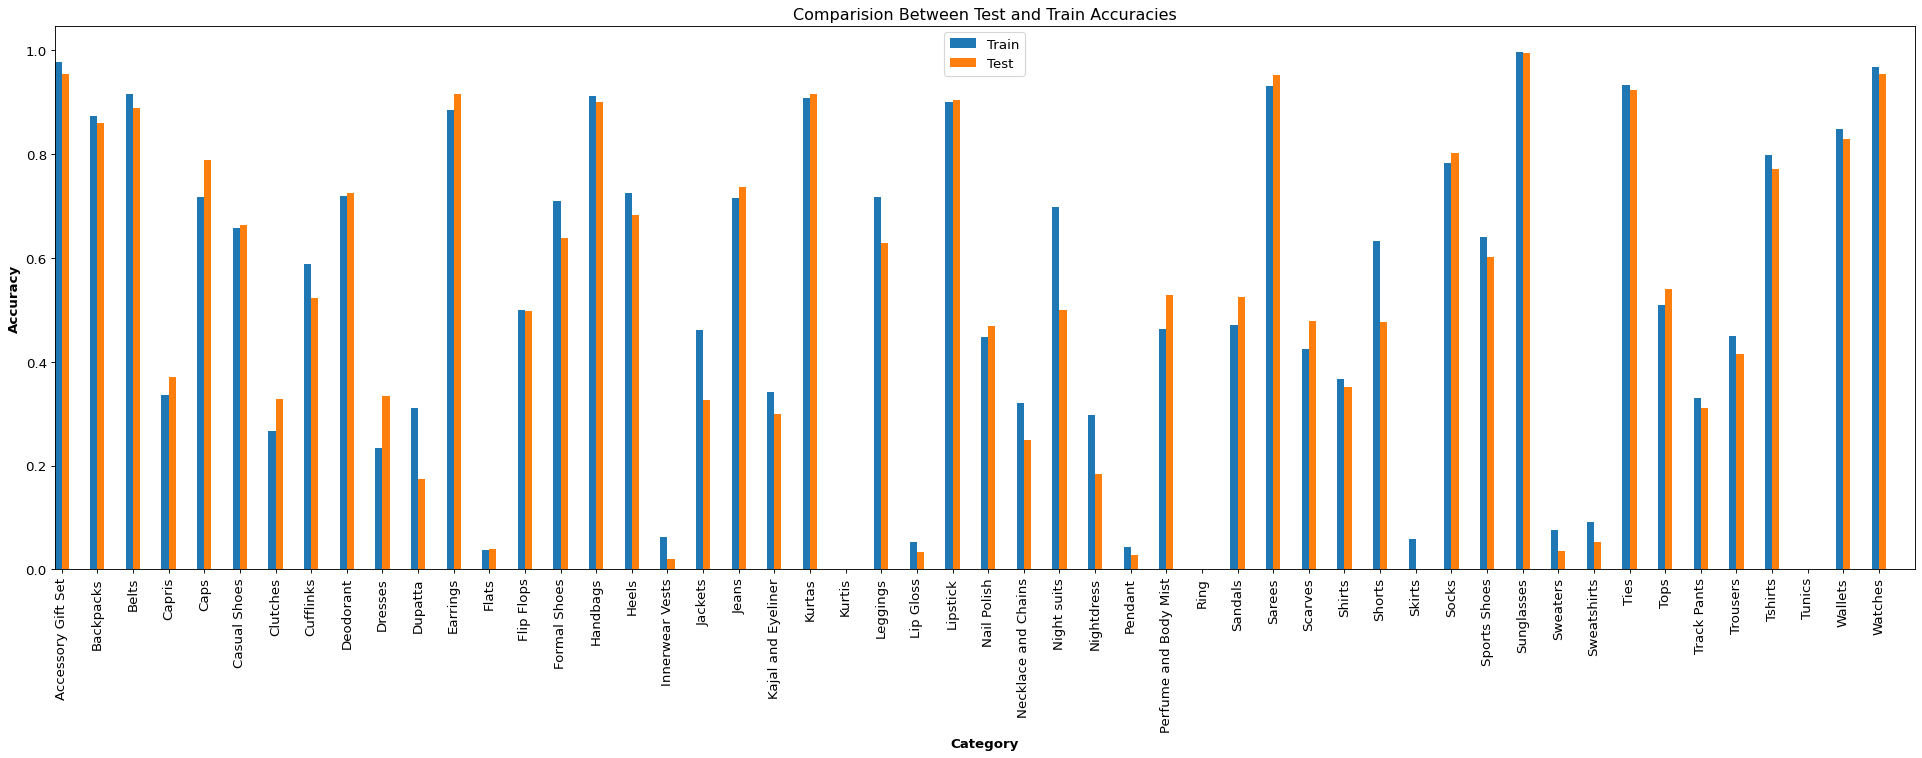

In [ ]:
learning_rates = [0.0005, 0.001, 0.005, 0.01, 0.05, 0.075, 0.1]

for lr in learning_rates:
    print('Learning Rate:', lr)
    model = Model(image_size, [10000, 5000, 1000, 200] , len(classes), F.relu)
    model = model.to(device)
    optimizer = torch.optim.SGD(model.parameters(), lr=lr)
    fit(model, scaled_train_loader, device, criterion, optimizer, num_epochs=10)
    analyse(model, scaled_train_loader, scaled_test_loader, classes)

<div lang="fa" dir="rtl">
<p>
همانطور که میبینیم، نتیجه برای وقتی که مقدار learning rate برابر
0.075 بود از بقیه ی حالات به مراتب بهتر و مدلمان دقیق تر بود.
</p>
<h3>
ب
</h3>
<p>
این موضوع به این دلیل است که چون تعداد epoch
های اجرا ثابت است و ده تاست، با leaarning rate های کم نمی توان در این تعداد epoch
به train loss پایین و جواب دقیقی رسید.

اگر بخواهیم با learning rate های پایین نتیجه بگیریم، باید تعداد epoch
ها را افزایش دهیم. (و برعکس).

بنابراین با learning rate
های پایین مدت زمان آموزش طولانی می شود و همگرایی خیلی دیر اتفاق می افتد.

همچنین ممکن است برنامه در یک مینیموم محلی گیر کرده و نتواند آن را برای رسیدن به مینیموم بهتر رد کند.

همچنین با زیاد شدن بیش از حد learning rate،
ممکن است در مسیر کم کردن loss، بدلیل تغییرات زیاد وزن ها از یک مینیموم محلی مناسب عبور کنیم و آن را از دست بدهیم.

زیاد بودن بیش از حد learning rate همچنین می تواند باعث پرت شدن از مسیر پیشرفت شود، بطوریکه نرخ loss رفته رفته افزایش یافته و منجر به همگرایی نشود.

که این مورد می تواند باعث فاصله گرفتن دقت تشخیص داده های تست و آموزش نیز بشود.

در آزمایش خود نیز مشاهده کردیم که با learning rate کم، مدل اصلا دقیق نبود و افزایش بیش از حد learning rate
نیز از دقت مدل کاسته می شد.

به همین دلیل مقدار learning rate نباید خیلی زیاد و نه خیلی کم باشد.

بنابراین learning rate
بهینه را برای استفاده های بعدی، ست می کنیم:
</p>
</div>

In [ ]:
learning_rate = 0.075

<div lang="fa" dir="rtl">
<h2>
بخش هفتم
</h2>
<h3>
الف
</h3>
<p>
در این بخش مقادیر batch size
را تغییر می دهیم تا تاثیرات آن بر یادگیری و دقت دسته بندی خود را مشاهده کنیم.
</p>
</div>

Batch Size: 32
epoch 1, train_loss: 2.574, time elapsed: 35.696135 seconds
epoch 2, train_loss: 1.797, time elapsed: 35.848876 seconds
epoch 3, train_loss: 1.528, time elapsed: 36.10876 seconds
epoch 4, train_loss: 1.347, time elapsed: 35.864031 seconds
epoch 5, train_loss: 1.228, time elapsed: 35.91003 seconds
epoch 6, train_loss: 1.145, time elapsed: 35.677821 seconds
epoch 7, train_loss: 1.075, time elapsed: 35.857008 seconds
epoch 8, train_loss: 1.017, time elapsed: 35.819714 seconds
epoch 9, train_loss: 0.966, time elapsed: 35.767637 seconds
epoch 10, train_loss: 0.925, time elapsed: 35.864015 seconds


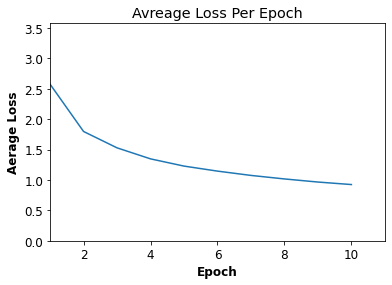

total training time: 5.974 minutes
Train Accuracy: 45.608913050773516%
Test Accuracy: 44.281879194630875%


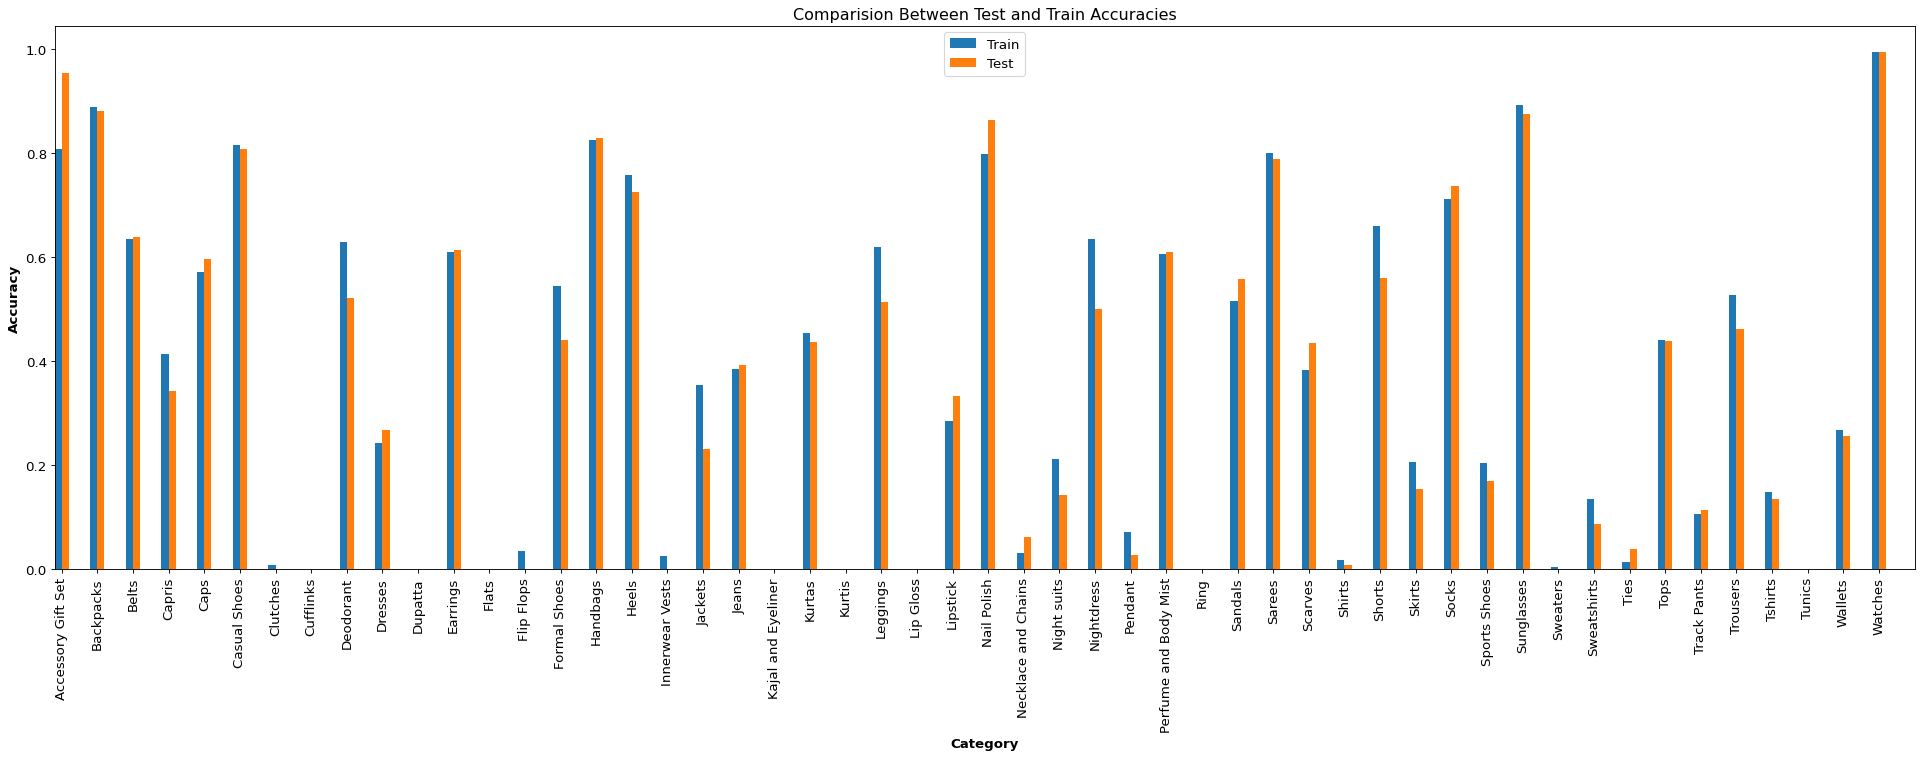

Batch Size: 128
epoch 1, train_loss: 3.135, time elapsed: 15.96052 seconds
epoch 2, train_loss: 2.399, time elapsed: 15.804931 seconds
epoch 3, train_loss: 2.030, time elapsed: 15.803208 seconds
epoch 4, train_loss: 1.793, time elapsed: 15.872454 seconds
epoch 5, train_loss: 1.577, time elapsed: 15.816748 seconds
epoch 6, train_loss: 1.516, time elapsed: 15.733993 seconds
epoch 7, train_loss: 1.391, time elapsed: 15.747529 seconds
epoch 8, train_loss: 1.299, time elapsed: 15.832995 seconds
epoch 9, train_loss: 1.236, time elapsed: 15.698484 seconds
epoch 10, train_loss: 1.198, time elapsed: 15.745511 seconds


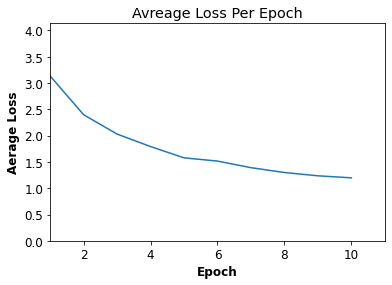

total training time: 2.634 minutes
Train Accuracy: 60.64297459646297%
Test Accuracy: 59.946308724832214%


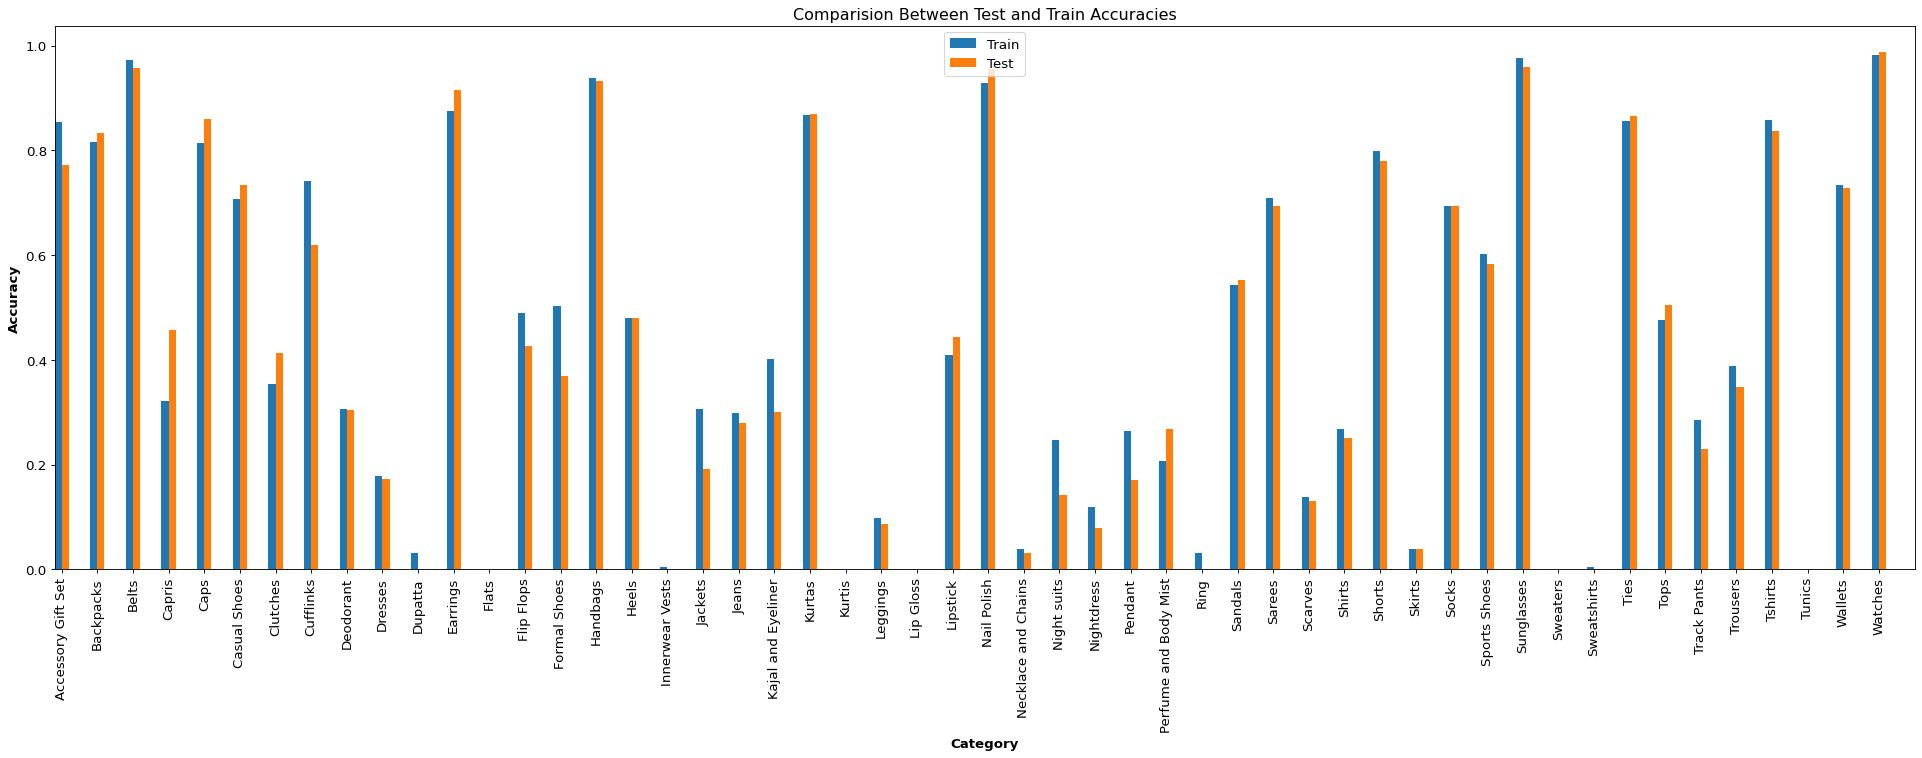

In [ ]:
for batch_size in [32, 128]:
    print('Batch Size:', batch_size)
    new_scaled_train_loader = torch.utils.data.DataLoader(scaled_train, batch_size=batch_size, num_workers=16)
    new_scaled_test_loader = torch.utils.data.DataLoader(scaled_test, batch_size=batch_size, num_workers=16)
    new_model = Model(image_size, [10000, 5000, 1000, 200] , len(classes), F.relu)
    new_model = new_model.to(device)
    optimizer = torch.optim.SGD(new_model.parameters(), lr=learning_rate)
    fit(new_model, new_scaled_train_loader, device, criterion, optimizer, num_epochs=10)
    analyse(new_model, new_scaled_train_loader, new_scaled_test_loader, classes)

<div lang="fa" dir="rtl">
<p>
همانطور که مشاهده می کنیم با زیاد شدن مقدار batch size،
تعداد iteration ها در 
هر epoch
کم می شود و این باعث می شود تا تعداد دفعات کمتری وزن های خود را آپدیت کنیم و دقتمان در تعداد epoch های کم، کمتر می شود.

همچنین چون در هر iteration
تعداد زیادی از داده ها را انتخاب می کنیم، به حافظه ی بیشتری نیاز خواهیم داشت.

اما در عوض مدت زمان یادگیری کاهش می یابد.

درصورتیکه با کم کردن این پارامتر، مدت زمان یادگیری افزایش یافته و تعداد iteration های بیشتری خواهیم داشت.

همچنین دقت مدل نیز ممکن است بهمراه آن زیاد شود.

وقتی از batch size
با اندازه بالا استفاده می کنیم، امکان گیر افتادن در یک مینیموم محلی بیشتر است.

همچنین چون در هر مرحله تعداد داده های بیشتری را بررسی می کنیم، مسیر بهتری را برای تغییر وزن ها می توانیم انتخاب کنیم.

اما درحالت کلی با زیاد کردن تعداد epoch
ها، دقت در دو حالت 32 و 128، به یکدیگر نزدیک می شود و این نشان دهنده ی این است که در حالت batch size
بالا، با داشتن epoch
های بیشتر، می توان بخشی از این کاهش دقت را جبران کرد.

اما در نهایت مشاهده می کنیم که در هر دو حالت دقت مدل کاهش یافت و در نتیجه بهترین مقدار برای batch size
همان 64 است.
</p>
<h3>
معایب batch size بسیار بالا یا بسیار پایین
</h3>
<p>
اگر مقدار batch size
خیلی بالا باشد، ممکن است به سمت یک مینیموم محلی همگرا شویم و یا overfitting رخ دهد.

همچنین درصورتی که مقدار این پارامتر خیلی کم باشد، ممکن است در batch
ها مقادیر نویز باعث شوند تا به سمت مسیر غلطی حرکت کنیم و وزن ها رو اشتباه بروز کنیم.

در batch size 32 که
آن را تست کردیم نیز ممکن است این اتفاق رخ داده باشد.
</p>
</div>

<div lang="fa" dir="rtl">
<h3>
ب
</h3>
<p>
با افزایش batch size،
اندازه learning rate نیز باید افزایش یابد.

برای بررسی این موضوع، با batch size 128 یکبار learning rate
را زیاد کرده و بار دیگر آن را کم می کنیم.
</p>
</div>

Batch Size: 128 Learning Rate 0.01
epoch 1, train_loss: 3.603, time elapsed: 15.764308 seconds
epoch 2, train_loss: 3.235, time elapsed: 15.6781 seconds
epoch 3, train_loss: 2.822, time elapsed: 15.7502 seconds
epoch 4, train_loss: 2.589, time elapsed: 15.814068 seconds
epoch 5, train_loss: 2.358, time elapsed: 15.809018 seconds
epoch 6, train_loss: 2.170, time elapsed: 15.782377 seconds
epoch 7, train_loss: 2.007, time elapsed: 15.877559 seconds
epoch 8, train_loss: 1.871, time elapsed: 15.730794 seconds
epoch 9, train_loss: 1.769, time elapsed: 15.751042 seconds
epoch 10, train_loss: 1.687, time elapsed: 15.777457 seconds


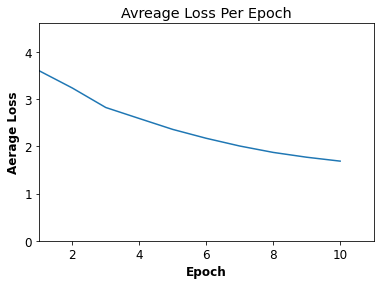

total training time: 2.629 minutes
Train Accuracy: 41.88060002013491%
Test Accuracy: 42.442953020134226%


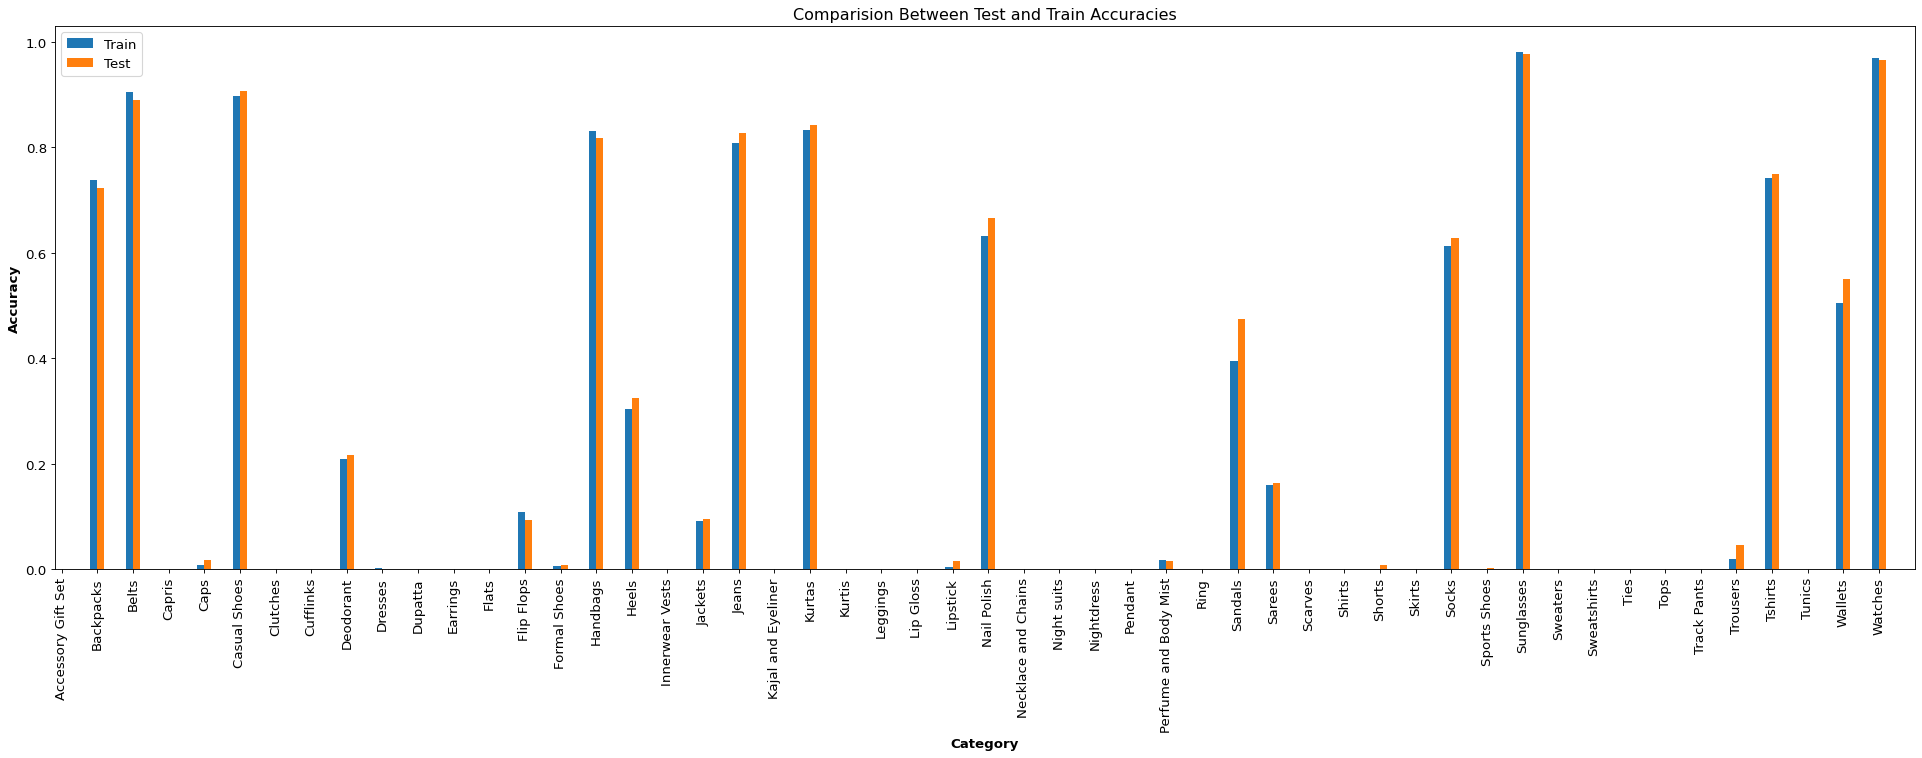

Batch Size: 128 Learning Rate 0.085
epoch 1, train_loss: 3.105, time elapsed: 15.690829 seconds
epoch 2, train_loss: 2.396, time elapsed: 15.663381 seconds
epoch 3, train_loss: 2.029, time elapsed: 15.644786 seconds
epoch 4, train_loss: 1.792, time elapsed: 15.69392 seconds
epoch 5, train_loss: 1.645, time elapsed: 15.689237 seconds
epoch 6, train_loss: 1.533, time elapsed: 15.696656 seconds
epoch 7, train_loss: 1.393, time elapsed: 15.635989 seconds
epoch 8, train_loss: 1.321, time elapsed: 15.682588 seconds
epoch 9, train_loss: 1.242, time elapsed: 15.68249 seconds
epoch 10, train_loss: 1.201, time elapsed: 15.679296 seconds


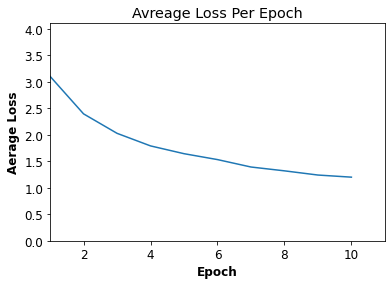

total training time: 2.613 minutes
Train Accuracy: 61.260444981375215%
Test Accuracy: 60.738255033557046%


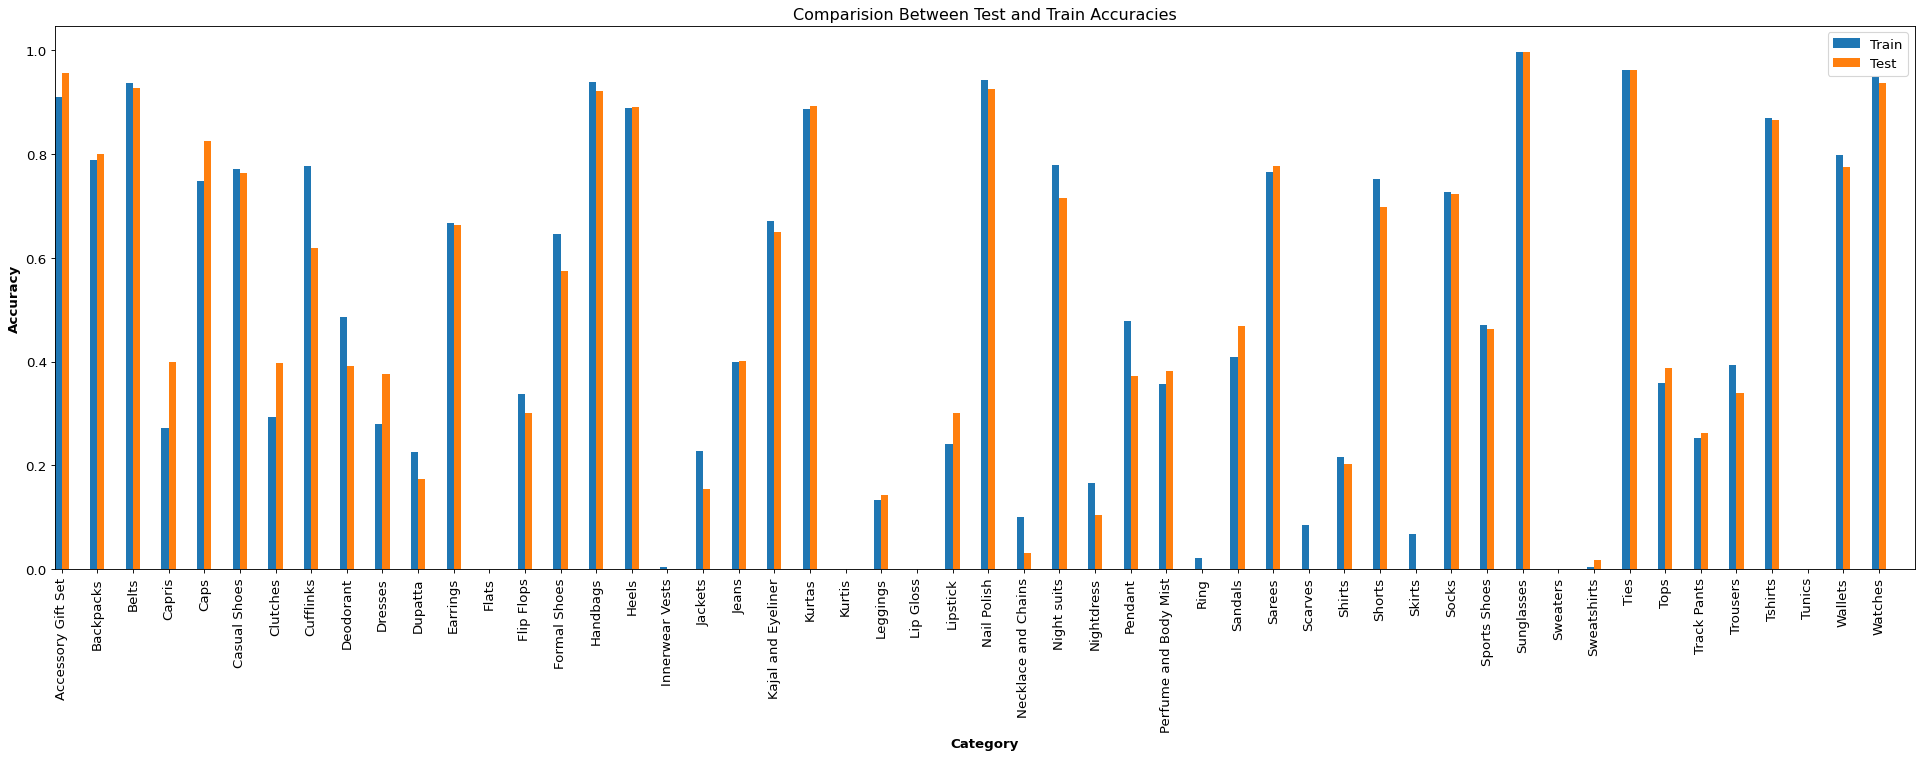

In [ ]:
for learning_rate in [0.01, 0.085]:
    batch_size = 128
    print('Batch Size:', batch_size, 'Learning Rate', learning_rate)
    new_scaled_train_loader = torch.utils.data.DataLoader(scaled_train, batch_size=batch_size, num_workers=16)
    new_scaled_test_loader = torch.utils.data.DataLoader(scaled_test, batch_size=batch_size, num_workers=16)
    new_model = Model(image_size, [10000, 5000, 1000, 200] , len(classes), F.relu)
    new_model = new_model.to(device)
    optimizer = torch.optim.SGD(new_model.parameters(), lr=learning_rate)
    fit(new_model, new_scaled_train_loader, device, criterion, optimizer, num_epochs=10)
    analyse(new_model, new_scaled_train_loader, new_scaled_test_loader, classes)

<div lang="fa" dir="rtl">
<p>
همانطور که مشاهده می کنیم،
با افزایش batch size،
اندازه learning rate نیز باید افزایش یابد.

چون در هر iteration
تعداد داده های بیشتری را بررسی کردیم و نیز تعداد iteration
هایمان کمتر است، بنابر این باید با قدم های بزرگتری به سمت مینیموم حرکت کنیم تا مدلمان همگرا شود.

در بررسی خود نیز مشاهده کردیم که افزایش learning rate
بهمراه افزایش batch size،
دقت مدل را نسبت به حالتی که فقط batch size
را افزایش دادیم، بهبود داد.
</p>
</div>

<div lang="fa" dir="rtl">
<h2>
بخش هشتم
</h2>
<h3>
الف
</h3>
<p>
پارامتر momenum
تعیین می کند که گام های قبلی یادگیری، تا چه اندازه بر گام بعدی ما در بروز کردن خطا و رسیدن به مینیموم موثر باشد.

بعبارت دیگر momentum
شبیه learning rate
است با این تفاوت که تاثیرات قدم های قبلی را در نظر می گیرد.

با اضافه کردن این ترم در بروز کردن loss،
سرعت پیشروی ما بیشتر می شود و می توانیم برخی گودال ها و مینیموم های محلی را بهتر رد کنیم.

استفاده نکردن از این مورد ممکن است باعث شود سرعت همگرایی کم باشد و یا در برخی مینیموم های محلی  گیر کنیم.

مقدار momentum بهتر است از مقدار learning rate
کمتر باشد.
</p>
<h3>
ب
</h3>
<p>
اکنون مقادیر مختلف را برای این پارامتر امتحان کرده و نتیجه را تحلیل می کنیم:
</p>
</div>

Momentum: 0.5
epoch 1, train_loss: 3.074, time elapsed: 26.38943 seconds
epoch 2, train_loss: 2.149, time elapsed: 26.286614 seconds
epoch 3, train_loss: 1.737, time elapsed: 26.597402 seconds
epoch 4, train_loss: 1.533, time elapsed: 26.557149 seconds
epoch 5, train_loss: 1.411, time elapsed: 26.572505 seconds
epoch 6, train_loss: 1.326, time elapsed: 26.441219 seconds
epoch 7, train_loss: 1.257, time elapsed: 26.458382 seconds
epoch 8, train_loss: 1.201, time elapsed: 26.469722 seconds
epoch 9, train_loss: 1.154, time elapsed: 26.372586 seconds
epoch 10, train_loss: 1.112, time elapsed: 26.509991 seconds


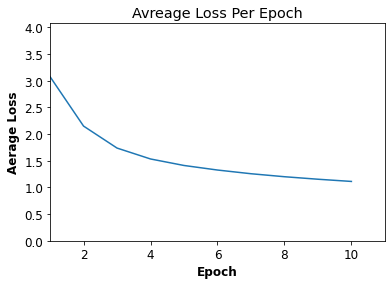

total training time: 4.411 minutes
Train Accuracy: 61.49870801033592%
Test Accuracy: 60.993288590604024%


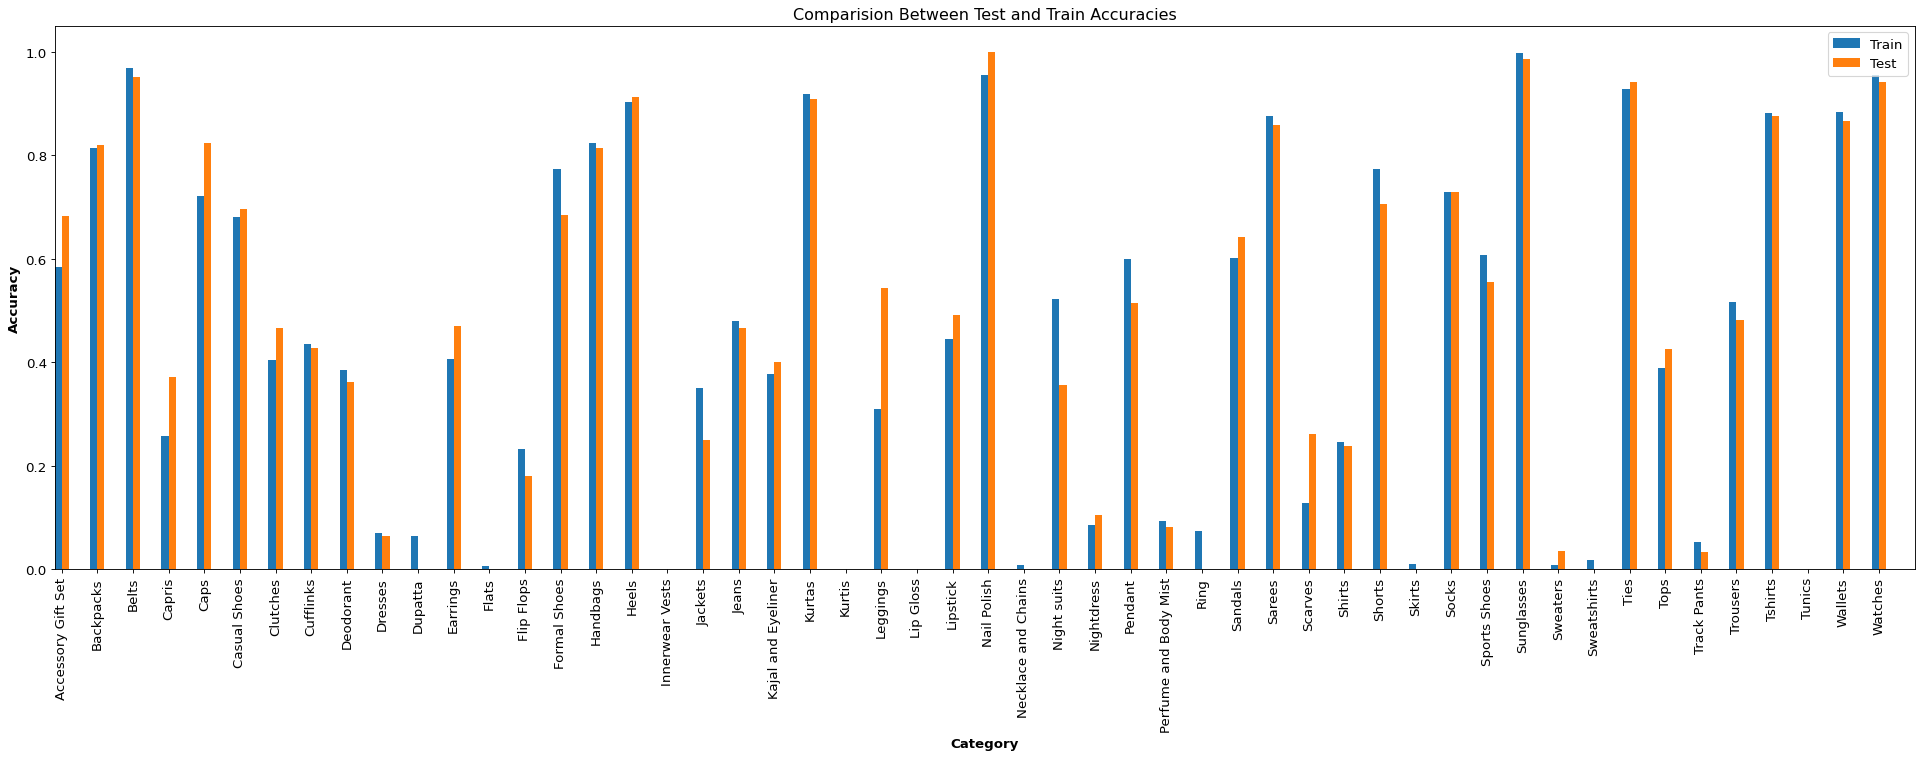

Momentum: 0.9
epoch 1, train_loss: 2.443, time elapsed: 26.468646 seconds
epoch 2, train_loss: 1.568, time elapsed: 26.384542 seconds
epoch 3, train_loss: 1.349, time elapsed: 26.325991 seconds
epoch 4, train_loss: 1.237, time elapsed: 26.34841 seconds
epoch 5, train_loss: 1.153, time elapsed: 26.289537 seconds
epoch 6, train_loss: 1.090, time elapsed: 26.335131 seconds
epoch 7, train_loss: 1.052, time elapsed: 26.277411 seconds
epoch 8, train_loss: 0.991, time elapsed: 26.284777 seconds
epoch 9, train_loss: 0.954, time elapsed: 26.260724 seconds
epoch 10, train_loss: 0.925, time elapsed: 26.299525 seconds


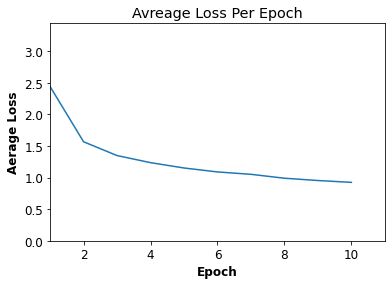

total training time: 4.388 minutes
Train Accuracy: 69.88153964898152%
Test Accuracy: 69.00671140939598%


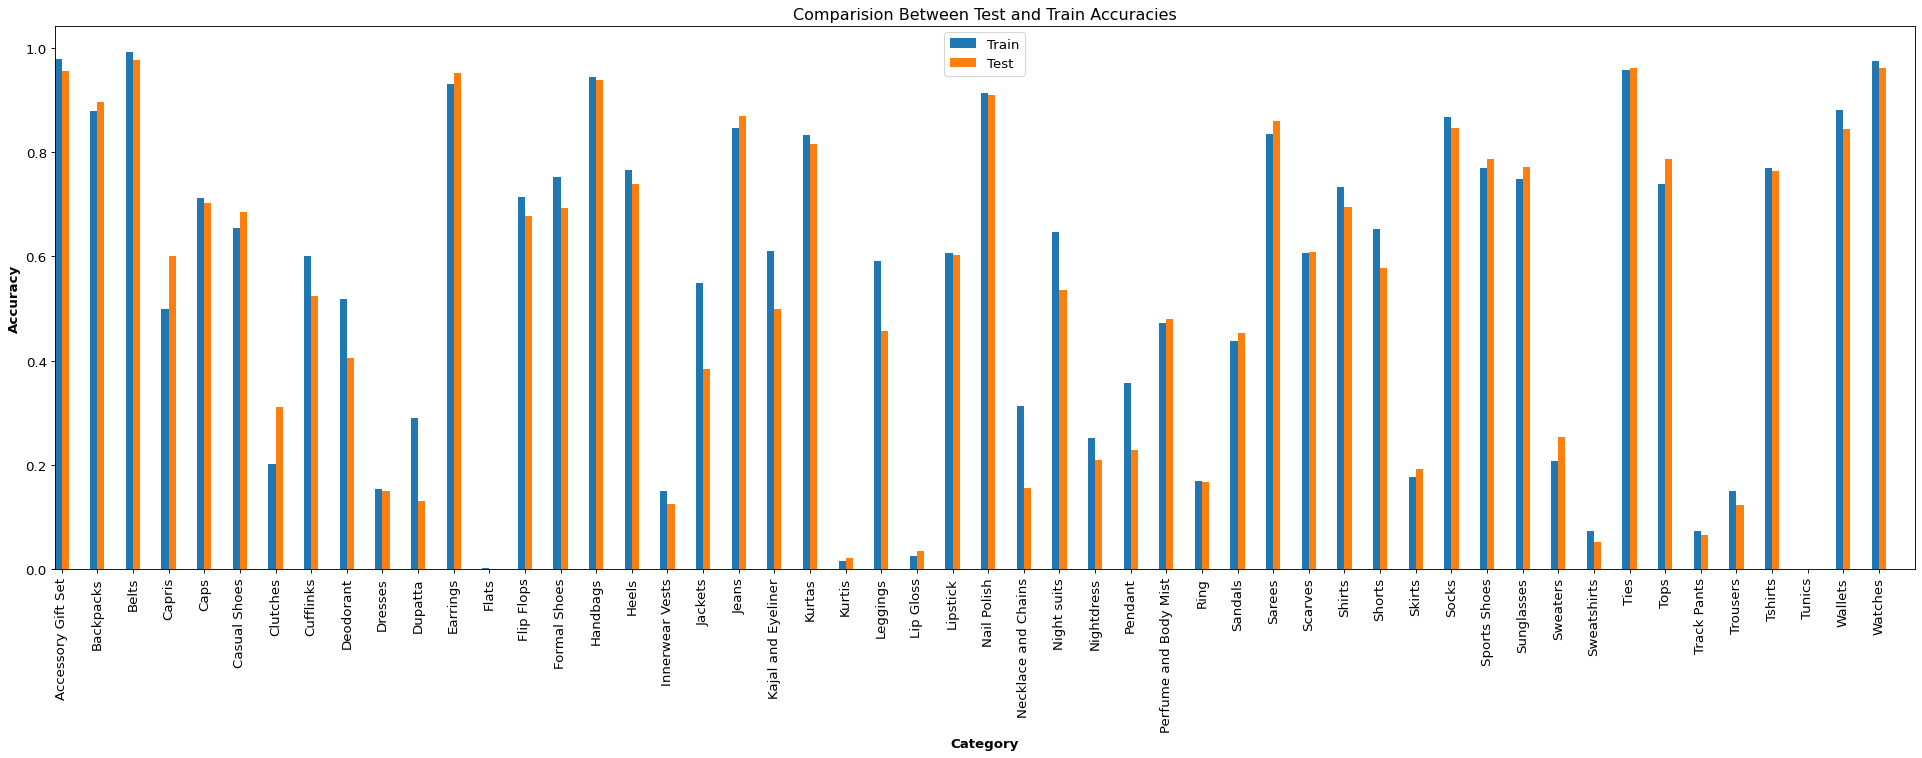

Momentum: 0.95
epoch 1, train_loss: 2.430, time elapsed: 26.337965 seconds
epoch 2, train_loss: 1.651, time elapsed: 26.20781 seconds
epoch 3, train_loss: 1.499, time elapsed: 26.13362 seconds
epoch 4, train_loss: 1.470, time elapsed: 26.01704 seconds
epoch 5, train_loss: 1.424, time elapsed: 26.018095 seconds
epoch 6, train_loss: 1.341, time elapsed: 25.952292 seconds
epoch 7, train_loss: 1.288, time elapsed: 25.940462 seconds
epoch 8, train_loss: 1.218, time elapsed: 26.009313 seconds
epoch 9, train_loss: 1.189, time elapsed: 25.908332 seconds
epoch 10, train_loss: 1.126, time elapsed: 25.974603 seconds


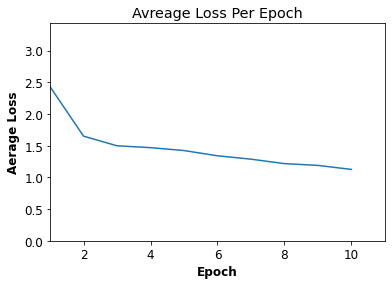

total training time: 4.342 minutes
Train Accuracy: 63.3779657035471%
Test Accuracy: 62.644295302013425%


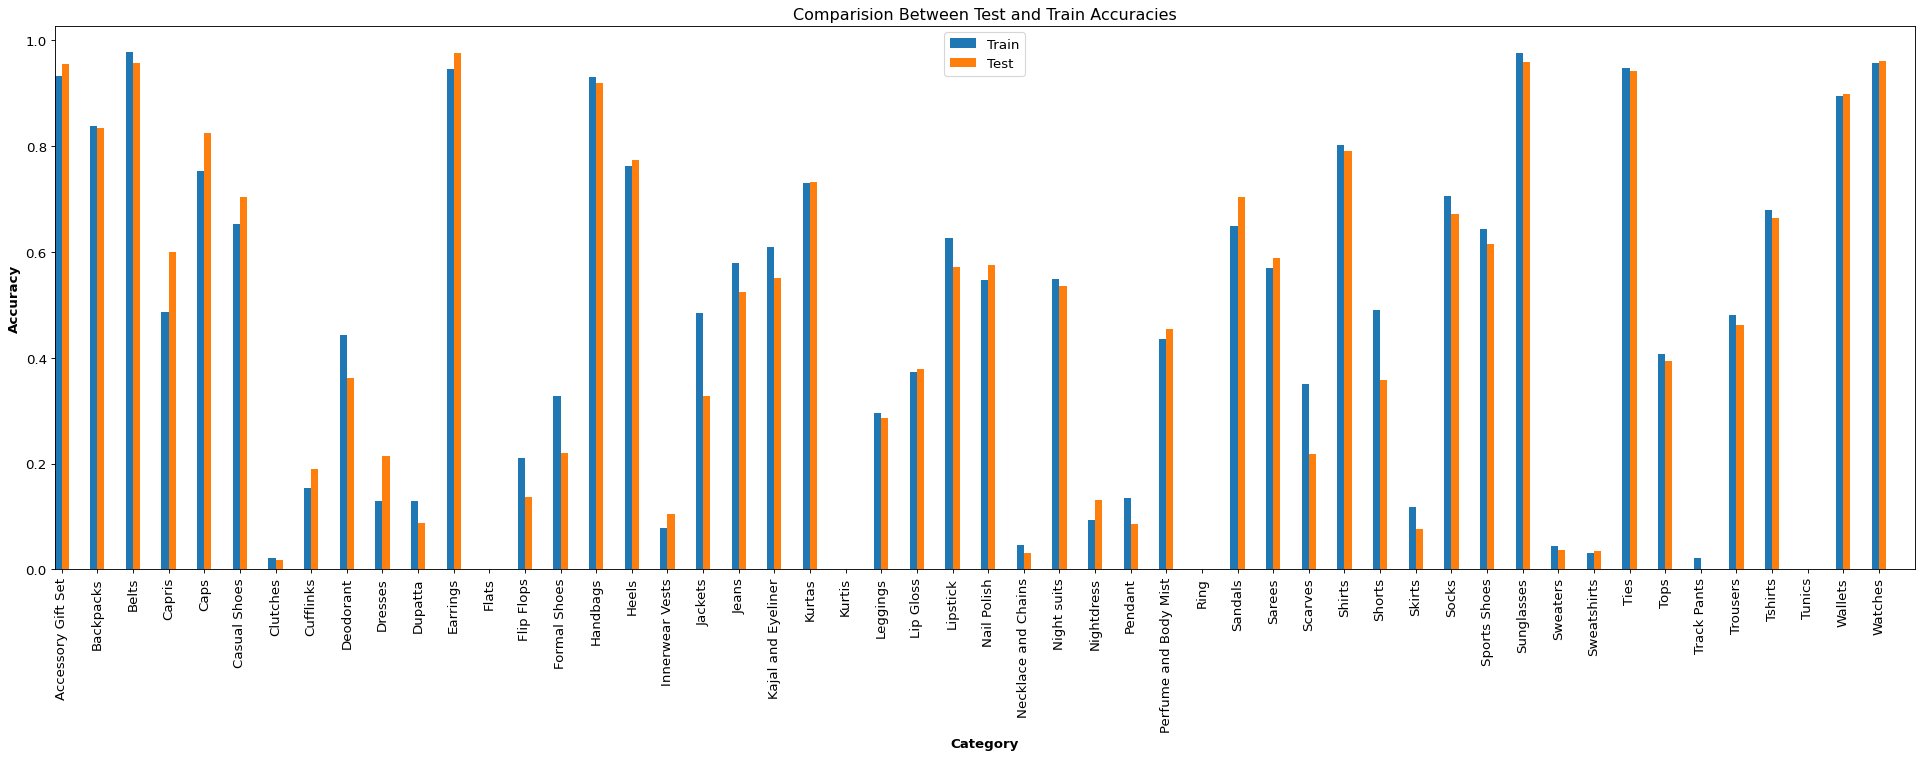

In [ ]:
for momentum in [0.5, 0.9, 0.95]:
    learning_rate = 0.01
    print('Momentum:', momentum)
    model = Model(image_size, [10000, 5000, 1000, 200] , len(classes), F.relu)
    model = model.to(device)
    optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=momentum)
    fit(model, scaled_train_loader, device, criterion, optimizer, num_epochs=10)
    analyse(model, scaled_train_loader, scaled_test_loader, classes)

<div lang="fa" dir="rtl">
<h3>
ب, پ
</h3>
<p>
همانطور که مشاهده می کنیم، وقتی مقدار momentum کم باشد یا صفر باشد، با همان learning rate اولیه ای که داشتیم، پیشرفتمان کند تر است و ممکن است در مینیمومی محلی گیر کنیم.

همچنین اگر مقدار momentum
بیش از حد زیاد باشد، قدم هایمان بسیار یزرگ شده و ممکن از مینیموم های مناسب را از دست داده و از روی آن ها عبور کنیم.

مانند مورد آخر که با momentum برابر 0.95
دقتمان از حالتی که برابر 0.9 بود کمتر شد که این نشان دهنده ی این است که افزایش momentum
لزوما دقت را افزایش نمی دهد.

بنابراین از مقدار 0.9 برای momentum
استفاده می کنیم که بهترین دقت را به مدلمان داد.
</p>
</div>

In [ ]:
momentum = 0.9

<div lang="fa" dir="rtl">
<h2>
بخش نهم
</h2>
<h3>
الف
</h3>
<p>
اکنون تعداد epoch ها را به 20
تغییر داده و مدل خود را آموزش می دهیم:
</p>
</div>

epoch 1, train_loss: 2.445, time elapsed: 26.319647 seconds
epoch 2, train_loss: 1.555, time elapsed: 26.345236 seconds
epoch 3, train_loss: 1.367, time elapsed: 26.247712 seconds
epoch 4, train_loss: 1.264, time elapsed: 26.389226 seconds
epoch 5, train_loss: 1.179, time elapsed: 26.372982 seconds
epoch 6, train_loss: 1.107, time elapsed: 26.361057 seconds
epoch 7, train_loss: 1.060, time elapsed: 26.476245 seconds
epoch 8, train_loss: 1.015, time elapsed: 26.459709 seconds
epoch 9, train_loss: 0.972, time elapsed: 26.431422 seconds
epoch 10, train_loss: 0.928, time elapsed: 26.406134 seconds
epoch 11, train_loss: 0.905, time elapsed: 26.315998 seconds
epoch 12, train_loss: 0.889, time elapsed: 26.397665 seconds
epoch 13, train_loss: 0.870, time elapsed: 26.318586 seconds
epoch 14, train_loss: 0.835, time elapsed: 26.358429 seconds
epoch 15, train_loss: 0.818, time elapsed: 26.323158 seconds
epoch 16, train_loss: 0.795, time elapsed: 26.306495 seconds
epoch 17, train_loss: 0.768, time

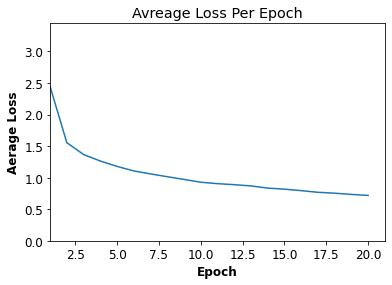

total training time: 8.783 minutes
Train Accuracy: 69.27413671599719%
Test Accuracy: 67.11409395973155%


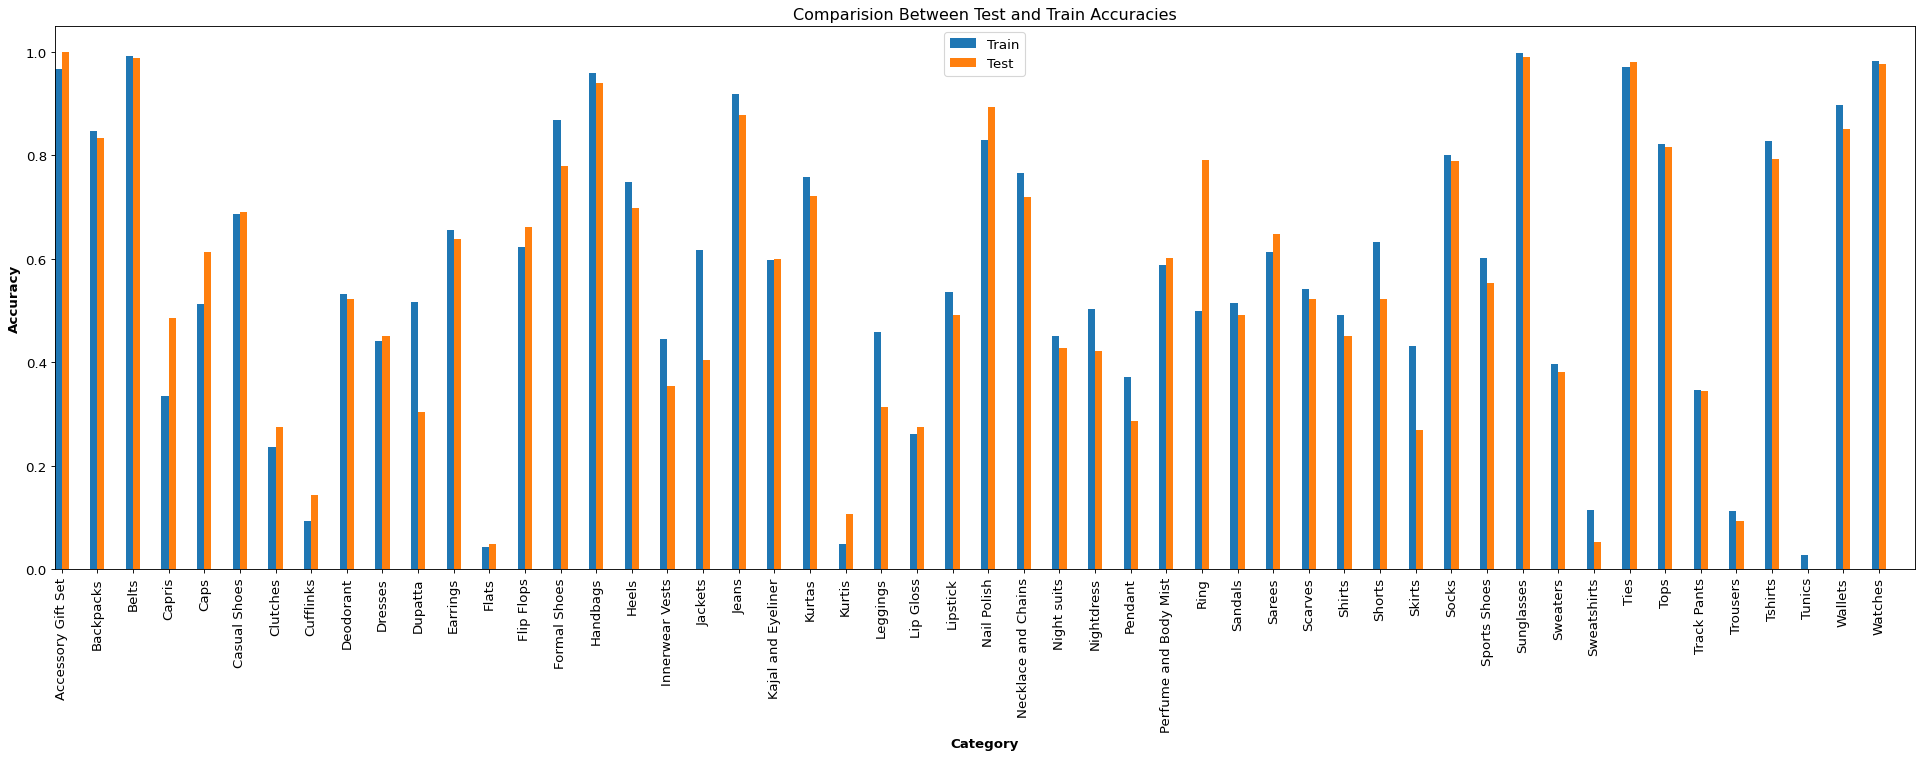

In [ ]:
model = Model(image_size, [10000, 5000, 1000, 200] , len(classes), F.relu)
model = model.to(device)
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=momentum)
fit(model, scaled_train_loader, device, criterion, optimizer, num_epochs=20)
analyse(model, scaled_train_loader, scaled_test_loader, classes)

<div lang="fa" dir="rtl">
<p>
همانطور که مشاهده می کنیم، با افزایش تعداد epoch ها
چون تعداد دفعات بیشتری در جهت کمتر کردن مقدا loss
تلاش می کنیم، دقت مدلمان برای داده های train اندکی افزایش می یابد.

اما در عوض مدت زمان آموزش نیز دو برابر می شود که در مقابل مقدار بهبودی بدست آمده در دقت، بسیار زیاد است.
</p>
<h3>
ب
</h3>
<p>
از آنجاییکه ممکن است در یک epoch مدلمان 
همگرا نشود و باتوجه به learning rate
ای که داریم، به مینیموم نرسیم، نیاز است تا بیش از یک epoch
داشته باشیم.

در حقیقت وقتی در اولین epoch تشخیص می دهیم که
باید در کدام سمت حرکت کنیم تا مقدار loss
را کمینه کنیم، به اندازه ای در آن جهت حرکت می کنیم اما در اولین قدم به مقدار کمینه نمیرسیم.

بنابراین باید چندین epoch
داشته باشیم.
</p>
<h3>
پ
</h3>
<p>
خیر. وقتی مدل ما به یک مینیمومی همگرا شده باشد، دیگر زیاد کردن تعداد epoch ها تاثیری
در دقت ندارد و مقدار loss
تغییر چندانی نمی کند.

چون مدل به مینیموم خود رسیده و به هر سمتی که حرکت کند به loss
کمتری نخواهد رسید و بنابراین در همانجا خواهد ماند.

همچنین تعداد epoch های زیاد ممکن است باعث overfitting
شود.

همانطور که در اینجا باعث شد تا دقت مدل بر روی داده های تست اندکی کاهش یابد.
</p>
</div>

<div lang="fa" dir="rtl">
<h2>
بخش دهم
</h2>
<p>
اکنون توابع tanh
و leaky relu
را بعنوان activation function
قرار می دهیم و تغییرات را بررسی می کنیم:
</p>
</div>

Activation Function: leaky_relu
epoch 1, train_loss: 2.422, time elapsed: 26.95153 seconds
epoch 2, train_loss: 1.573, time elapsed: 26.517651 seconds
epoch 3, train_loss: 1.368, time elapsed: 26.484847 seconds
epoch 4, train_loss: 1.243, time elapsed: 26.474228 seconds
epoch 5, train_loss: 1.154, time elapsed: 26.486544 seconds
epoch 6, train_loss: 1.098, time elapsed: 26.42216 seconds
epoch 7, train_loss: 1.046, time elapsed: 26.409412 seconds
epoch 8, train_loss: 1.015, time elapsed: 26.396126 seconds
epoch 9, train_loss: 0.957, time elapsed: 26.461817 seconds
epoch 10, train_loss: 0.929, time elapsed: 26.418804 seconds


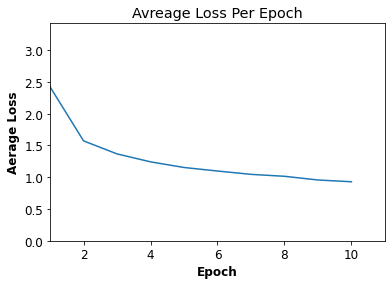

total training time: 4.417 minutes
Train Accuracy: 67.60629551327226%
Test Accuracy: 66.22818791946308%


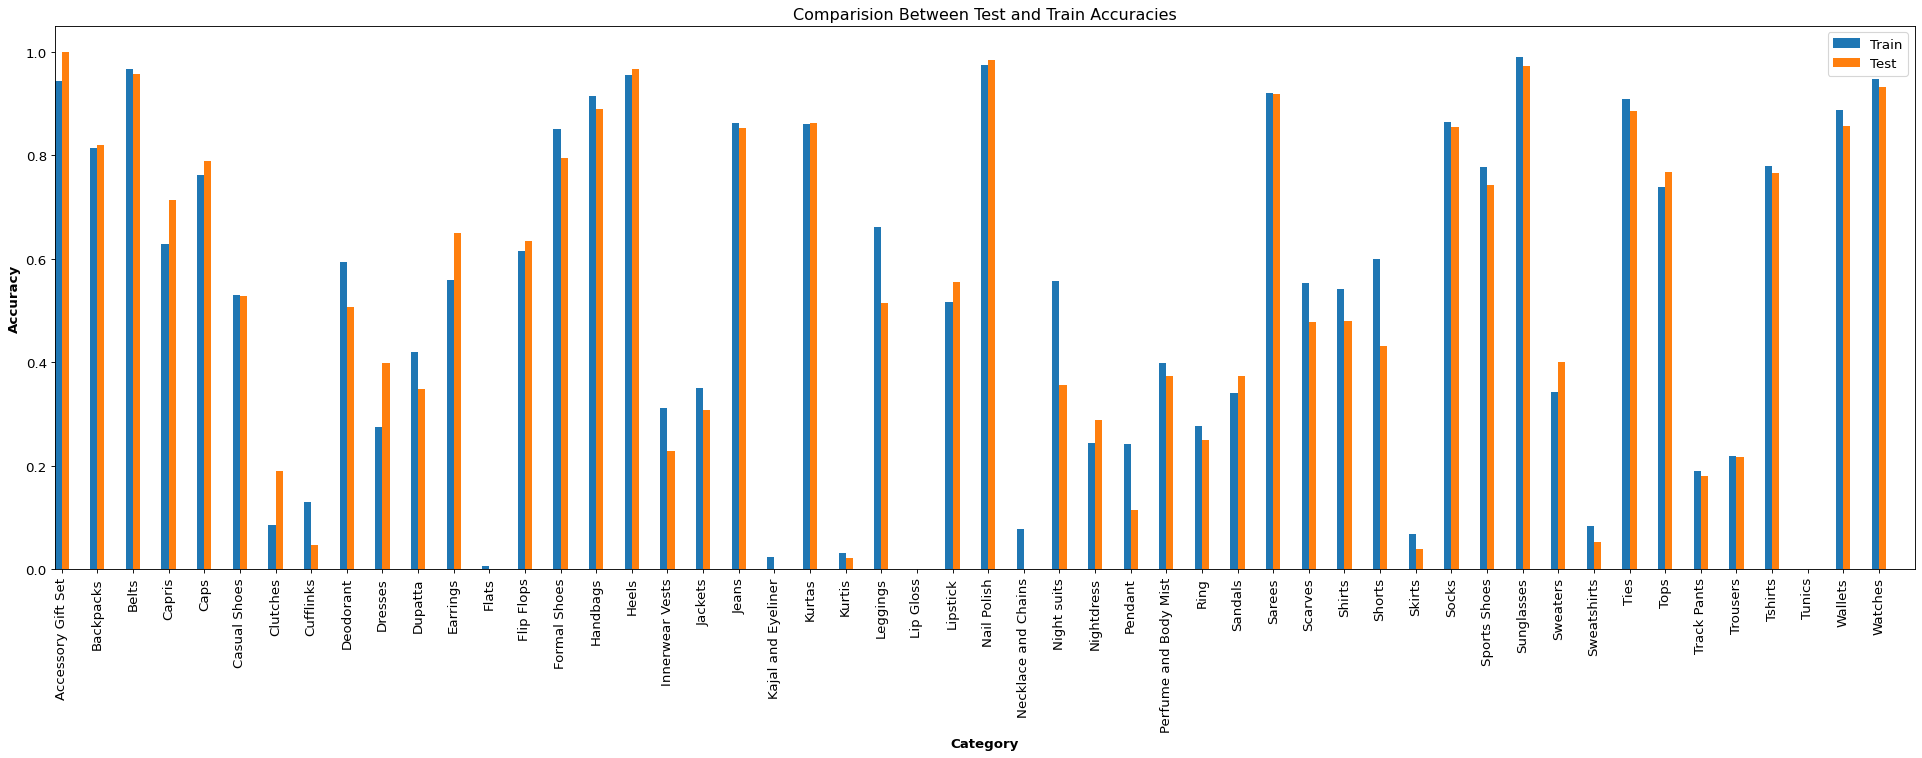

Activation Function: tanh
epoch 1, train_loss: 2.075, time elapsed: 26.576669 seconds
epoch 2, train_loss: 1.337, time elapsed: 26.430209 seconds
epoch 3, train_loss: 1.205, time elapsed: 26.426994 seconds
epoch 4, train_loss: 1.093, time elapsed: 26.401695 seconds
epoch 5, train_loss: 1.024, time elapsed: 26.514658 seconds
epoch 6, train_loss: 0.966, time elapsed: 26.360286 seconds
epoch 7, train_loss: 0.923, time elapsed: 26.359686 seconds
epoch 8, train_loss: 0.882, time elapsed: 26.402391 seconds
epoch 9, train_loss: 0.861, time elapsed: 26.392285 seconds
epoch 10, train_loss: 0.828, time elapsed: 26.367823 seconds


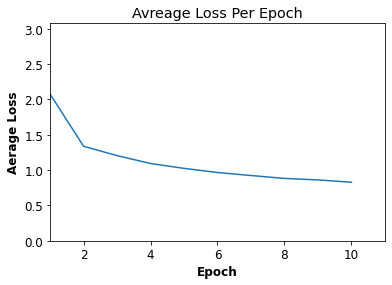

total training time: 4.404 minutes
Train Accuracy: 70.02248397597235%
Test Accuracy: 67.6241610738255%


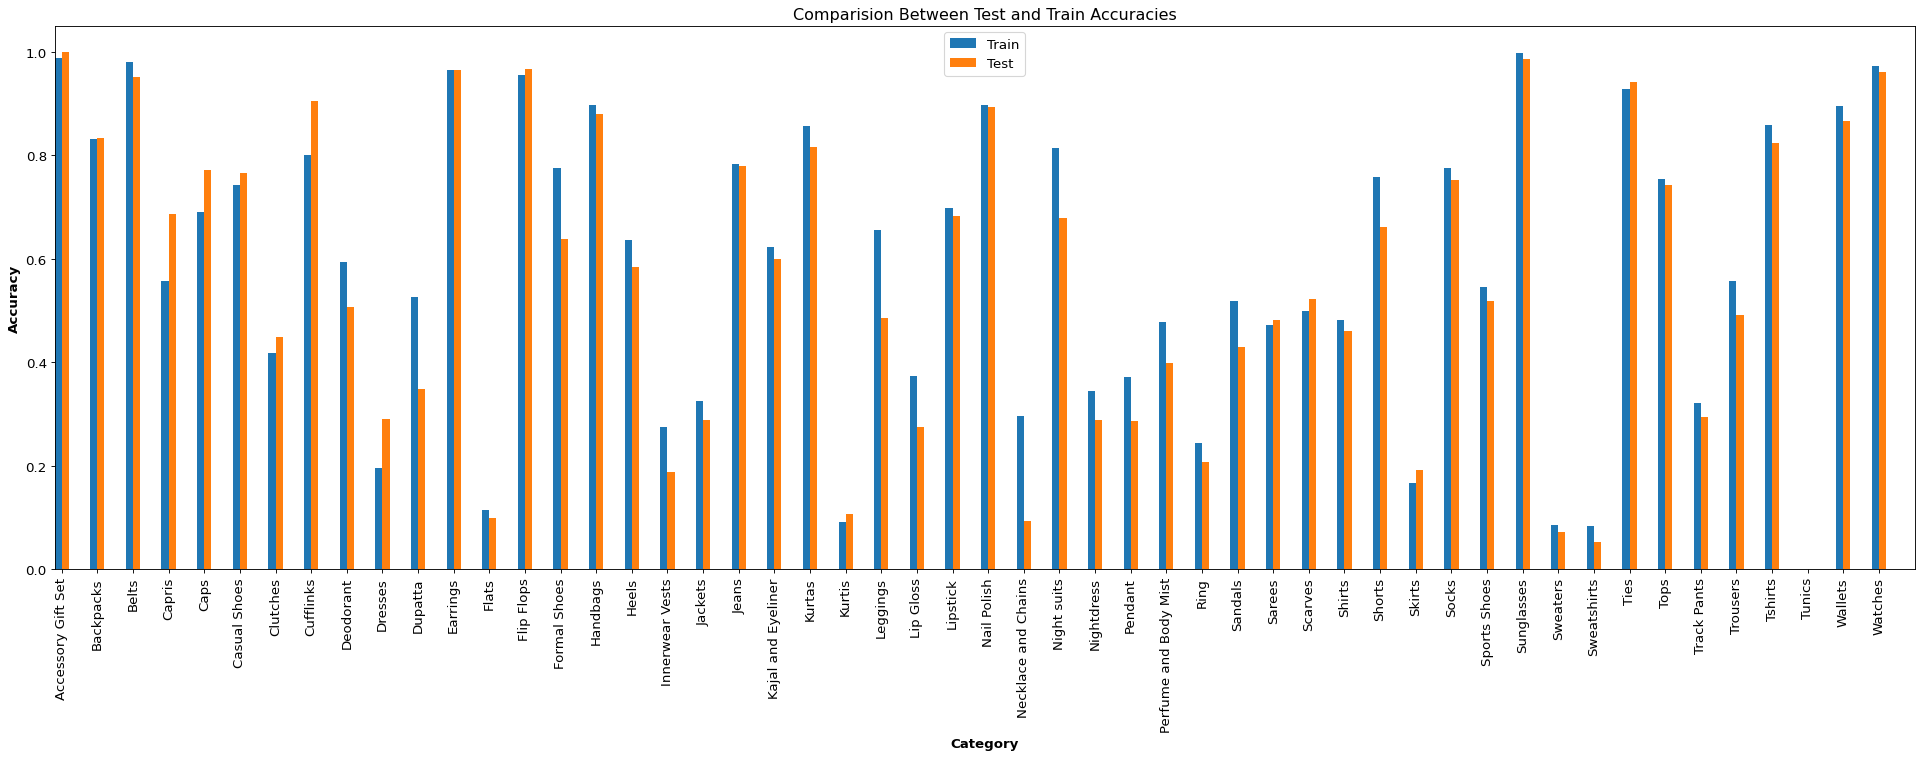

In [ ]:
for af in [F.leaky_relu, torch.tanh]:
    print('Activation Function:', 'leaky_relu' if af == F.leaky_relu else 'tanh')
    model = Model(image_size, [10000, 5000, 1000, 200] , len(classes), af)
    model = model.to(device)
    optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=momentum)
    fit(model, scaled_train_loader, device, criterion, optimizer, num_epochs=10)
    analyse(model, scaled_train_loader, scaled_test_loader, classes)

<div lang="fa" dir="rtl">
<p>
همانطور که مشاهده می کنیم، وقتی از تابع tanh
بعنوان activation function
استفاده کردیم، دقتمان تا حدی افزایش پیدا کرد که نشان از تاثیر این تابع بر آموزش مدلمان دارد.
</p>
</div>

<div lang="fa" dir="rtl">
<h2>
بخش یازدهم
</h2>
<h3>
الف
</h3>
<p>
افزودن این ترم در محاسبه ی loss
مقدار loss
را به اندازه ای زیاد می کند و بعبارتی مجموع ضرایب را نیز در مقدار loss
در نظر می گیرد که این کار باعث می شود از بسیار دقیق و جزئی شدن مدل جلوگیری شود.

در اصل در این روش سعی داریم مقدار وزن ها خیلی زیاد نشوند و از تولید وزن های بزرگ جلوگیری می کنیم.
</p>
<h3>
ب
</h3>
<p>
این پارامتر در اصل ضریبی است که در اضافه کردن مقدار regularization
استفاده می شود و برای مثال اگر regularization ما
مجموع همه ی وزن ها باشد، این مقدار در مقدار weight decay
ضرب شده و سپس با مقدار loss
جمع می شود.
</p>
<h3>
پ
</h3>
<p>
اکنون مقدار این پارامتر را برابر 0.1
گذاشته و مدل خود را مجددا آموزش می دهیم:
</p>
</div>

epoch 1, train_loss: 3.469, time elapsed: 29.554229 seconds
epoch 2, train_loss: 3.350, time elapsed: 29.573252 seconds
epoch 3, train_loss: 3.338, time elapsed: 29.569515 seconds
epoch 4, train_loss: 3.337, time elapsed: 29.553495 seconds
epoch 5, train_loss: 3.337, time elapsed: 29.51527 seconds
epoch 6, train_loss: 3.337, time elapsed: 29.569594 seconds
epoch 7, train_loss: 3.337, time elapsed: 29.548361 seconds
epoch 8, train_loss: 3.337, time elapsed: 29.540796 seconds
epoch 9, train_loss: 3.337, time elapsed: 29.548002 seconds
epoch 10, train_loss: 3.337, time elapsed: 29.611241 seconds


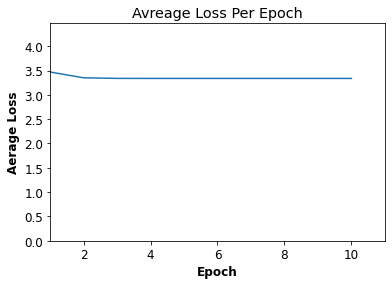

total training time: 4.926 minutes
Train Accuracy: 9.483539716097855%
Test Accuracy: 9.48993288590604%


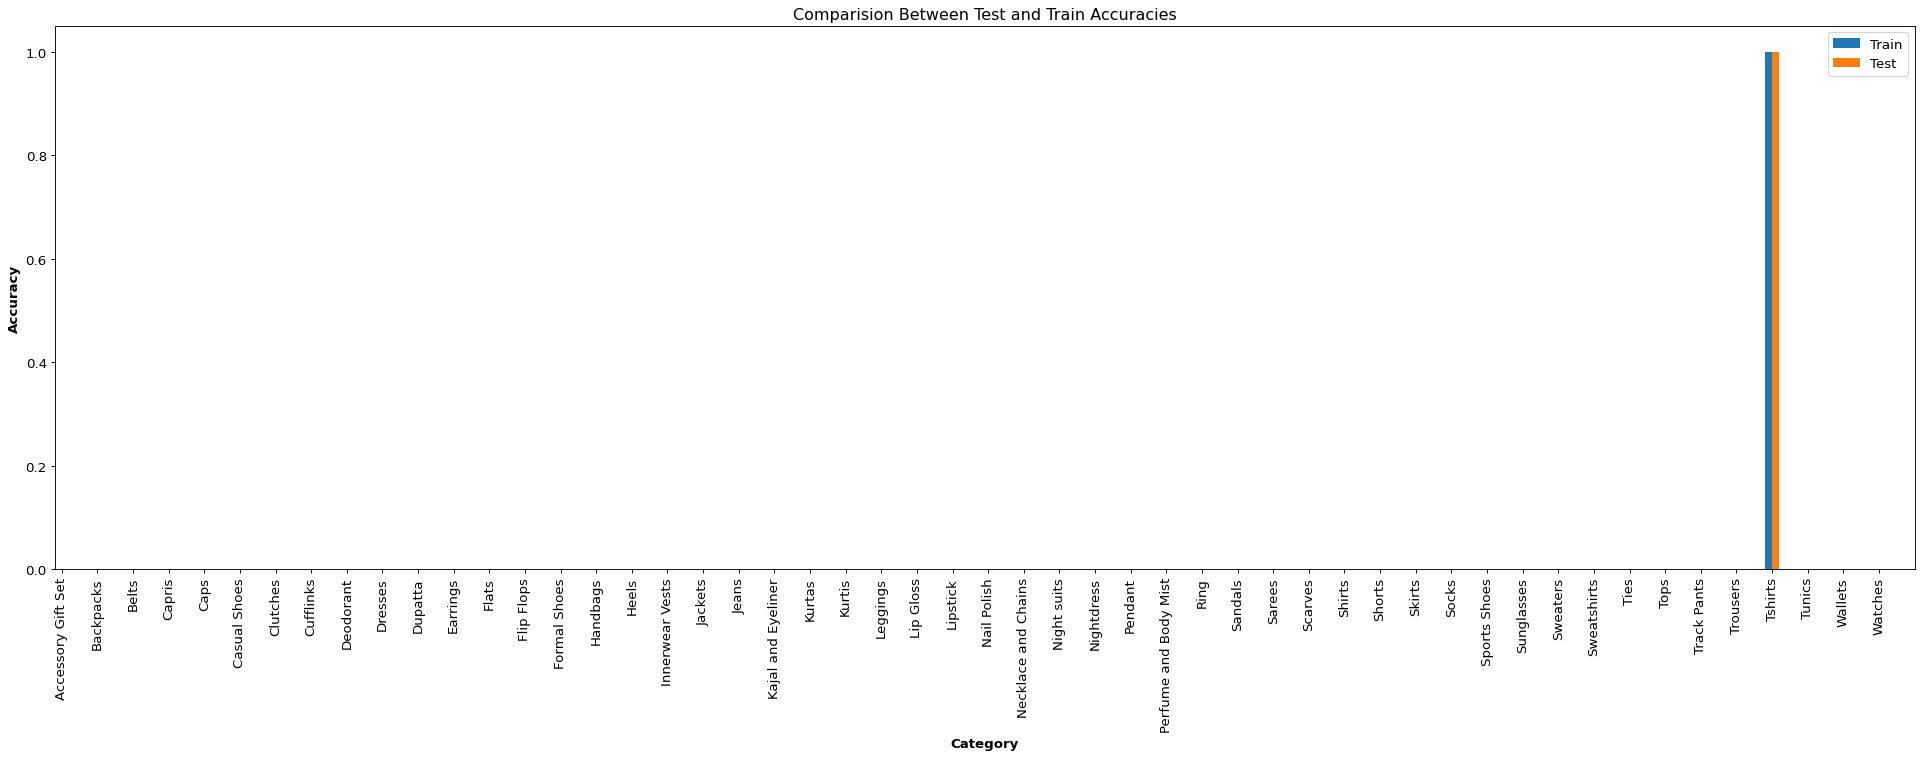

In [ ]:
model = Model(image_size, [10000, 5000, 1000, 200] , len(classes), F.relu)
model = model.to(device)
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=momentum, weight_decay=0.1)
fit(model, scaled_train_loader, device, criterion, optimizer, num_epochs=10)
analyse(model, scaled_train_loader, scaled_test_loader, classes)

<div lang="fa" dir="rtl">
<p>
همانطور که مشاهده می کنیم چون مقدار ضریب زیاد بود، وزن ها تغییر زیادی نکردند و مقدار loss
تقریبا ثابت باقی ماند.

این اتفاق به این دلیل است که در هر برار بروز رسانی وزن ها، مقدار زیادی به loss اضافه می شود که مانع کمتر شدن آن
و همگرایی مدل می شود.

با کمتر کردن تاثیر این پارامتر و مقدار اضافه شده به loss
می توان این مشکل را برطرف کرد.
</p>
<h3>
ت
</h3>
<p>
اکنون مقدار این پارامتر را برابر 0.01
گذاشته و مدل خود را مجددا آموزش می دهیم:
</p>
</div>

epoch 1, train_loss: 2.604, time elapsed: 29.642874 seconds
epoch 2, train_loss: 1.794, time elapsed: 29.594476 seconds
epoch 3, train_loss: 1.620, time elapsed: 29.560018 seconds
epoch 4, train_loss: 1.528, time elapsed: 29.532342 seconds
epoch 5, train_loss: 1.516, time elapsed: 29.575131 seconds
epoch 6, train_loss: 1.494, time elapsed: 29.54653 seconds
epoch 7, train_loss: 1.489, time elapsed: 29.585956 seconds
epoch 8, train_loss: 1.484, time elapsed: 29.58682 seconds
epoch 9, train_loss: 1.460, time elapsed: 29.591573 seconds
epoch 10, train_loss: 1.463, time elapsed: 29.627507 seconds


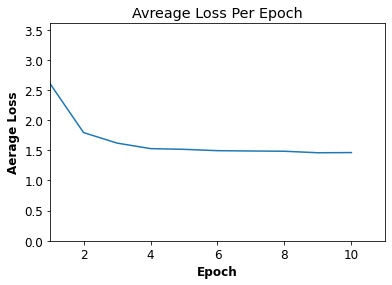

total training time: 4.931 minutes
Train Accuracy: 54.38437531460787%
Test Accuracy: 53.24832214765101%


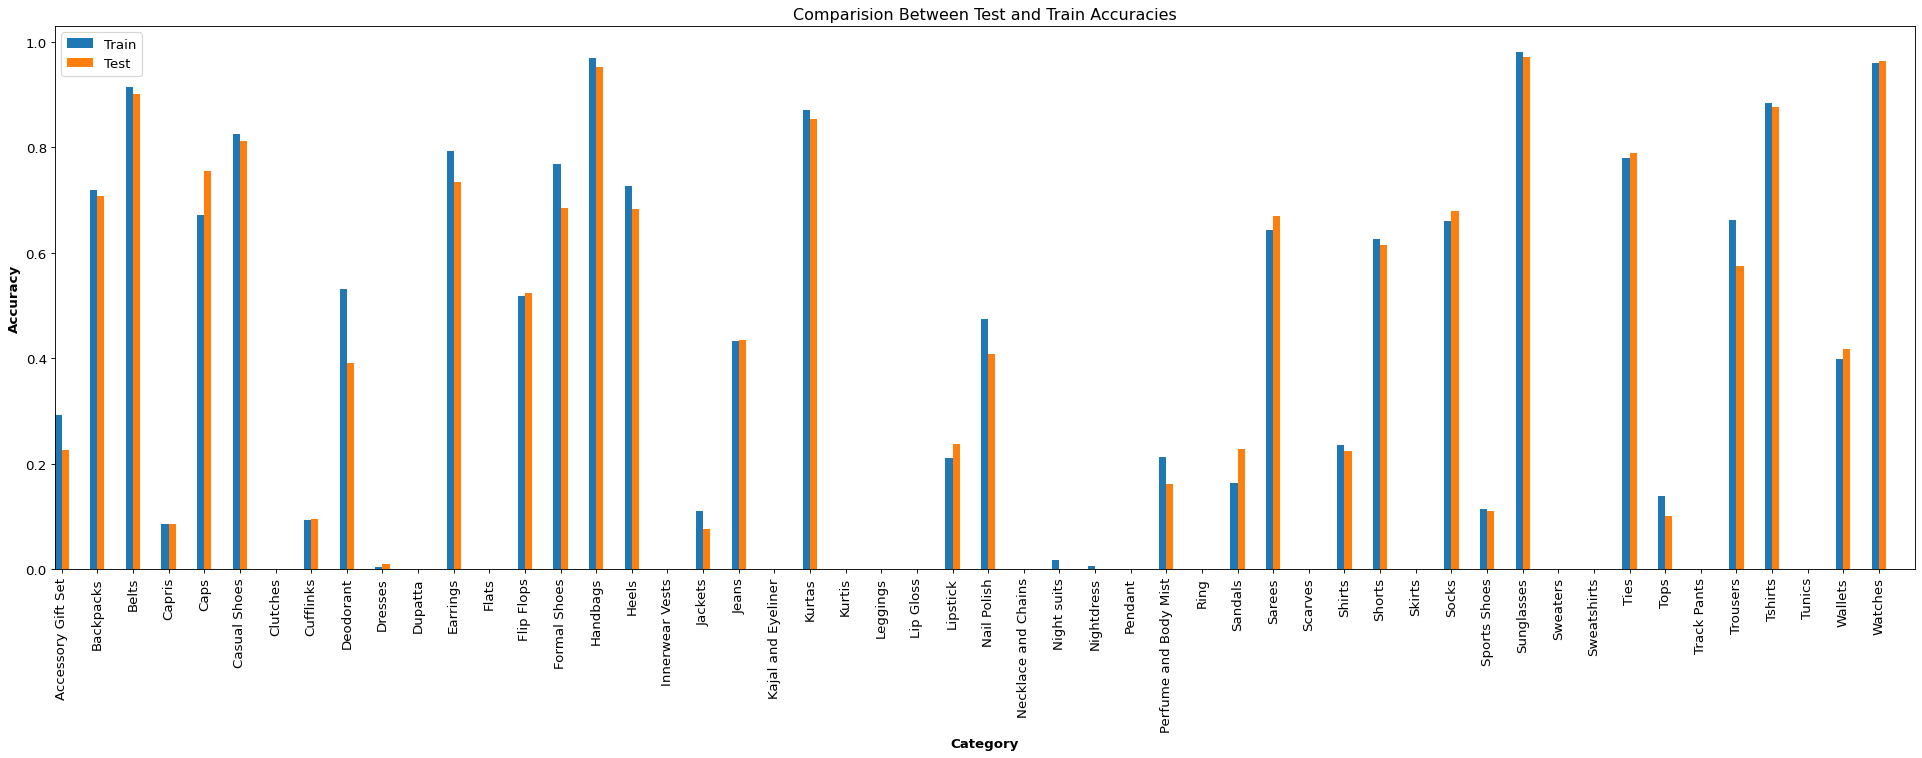

In [ ]:
model = Model(image_size, [10000, 5000, 1000, 200] , len(classes), F.relu)
model = model.to(device)
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=momentum, weight_decay=0.01)
fit(model, scaled_train_loader, device, criterion, optimizer, num_epochs=10)
analyse(model, scaled_train_loader, scaled_test_loader, classes)

<div lang="fa" dir="rtl">
<p>
همانطور که مشاهده می کنیم، مشکل ایجاد شده در بخش پ حل شد و مدل توانست یادگیری خود را انجام دهد.

اما به دلیل استفاده از regularization،
دقت خیلی بالا نرفت.

چون این کار باعث می شود که مقدار وزن ها خیلی زیاد نشوند و برای جلوگیری از overfitting
سعی می کند که مقدار وزن ها را کم نگه دارد.

به همین دلیل وزن ها دقیق نشدند و دقتمان کاهش پیدا کرد.
</p>
</div>